In [1]:
# Set OpenMP environment variables early to avoid libiomp conflicts
import os
os.environ.setdefault("KMP_DUPLICATE_LIB_OK", "TRUE")
os.environ.setdefault("OMP_NUM_THREADS", "1")

import numpy as np
import pandas as pd
import sympy as sy

# Try importing torch, but don't fail if it's not available
try:
    import torch
    TORCH_AVAILABLE = True
    print(f"PyTorch {torch.__version__} is available")
except ImportError:
    TORCH_AVAILABLE = False
    print("Warning: PyTorch is not installed. Using numpy/scipy for diagonalization.")
    torch = None

import ujson as uj

from copy import deepcopy
from functools import partial
from pathlib import Path

from sympy.physics.wigner import wigner_3j, wigner_6j
from numpy import linalg as LA
from IPython.display import Latex, display
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.collections import LineCollection
%matplotlib inline
import seaborn as sns

from scipy.optimize import least_squares
from scipy.stats import norm

import Energy_Levels_old as EL
from Energy_Levels_old import MoleculeLevels
from Energy_Levels_old import (
    branching_ratios,
    Calculate_TDMs,
    Calculate_TDM_evecs,
    Calculate_forbidden_TDM_evecs,
    Calculate_forbidden_TDMs,
)

print("All imports successful!")

# sns.set()
# sns.set_palette('bright')
# np.set_printoptions(precision=9, suppress=True)
# from tabulate import tabulate

PyTorch 2.5.1+cu121 is available
All imports successful!


In [2]:
# Torch device configuration and GPU-ready diagonalization hooks
# Only configure torch if it's available. Probe CUDA in a short subprocess
# and default to CPU if the probe fails to avoid kernel/driver crashes.
import subprocess, sys, time

if TORCH_AVAILABLE:
    try:
        # Default to CPU; enable CUDA only if a quick safe probe succeeds.
        TORCH_DEVICE = torch.device("cpu")
        cuda_ok = False
        if torch.cuda.is_available():
            probe_code = (
                "import torch, sys\n"
                "try:\n"
                "    x = torch.tensor([1.0], dtype=torch.float32).to('cuda')\n"
                "    torch.cuda.synchronize()\n"
                "    print('cuda_ok')\n"
                "except Exception as e:\n"
                "    print('cuda_fail', e)\n"
                "    sys.exit(1)\n"
            )
            try:
                res = subprocess.run([sys.executable, "-c", probe_code], capture_output=True, text=True, timeout=10)
                if res.returncode == 0 and "cuda_ok" in res.stdout:
                    TORCH_DEVICE = torch.device("cuda")
                    cuda_ok = True
                else:
                    print("CUDA probe failed; output:", res.stdout, res.stderr)
            except Exception as e:
                print("CUDA probe subprocess error:", e)

        print(f"Using torch device: {TORCH_DEVICE} (cuda_ok={cuda_ok})")
    except Exception as e:
        print(f"Warning: Could not configure torch device: {e}")
        TORCH_AVAILABLE = False
        TORCH_DEVICE = torch.device("cpu")
else:
    TORCH_DEVICE = None
    print("Torch not available, using numpy/scipy for diagonalization")

# Store original functions
if not hasattr(EL, "diagonalize_cpu"):
    EL.diagonalize_cpu = EL.diagonalize
    EL.diagonalize_batch_cpu = EL.diagonalize_batch

# ---- GPU profiling statistics ----
GPU_PROFILING = {
    "diagonalize_calls": 0,
    "diagonalize_cuda_calls": 0,
    "diagonalize_cpu_calls": 0,
    "diagonalize_batch_calls": 0,
    "diagonalize_batch_cuda_calls": 0,
    "diagonalize_batch_cpu_calls": 0,
    "total_time_cuda": 0.0,
    "total_time_cpu": 0.0,
    "total_time_batch_cuda": 0.0,
    "total_time_batch_cpu": 0.0,
}

def print_gpu_profile():
    """Print GPU profiling summary."""
    print("\n" + "="*70)
    print("GPU PROFILING SUMMARY")
    print("="*70)
    print(f"Single diagonalize() calls: {GPU_PROFILING['diagonalize_calls']}")
    print(f"  ├─ CUDA: {GPU_PROFILING['diagonalize_cuda_calls']} (total time: {GPU_PROFILING['total_time_cuda']:.4f}s)")
    print(f"  └─ CPU:  {GPU_PROFILING['diagonalize_cpu_calls']} (total time: {GPU_PROFILING['total_time_cpu']:.4f}s)")
    print(f"\nBatch diagonalize_batch() calls: {GPU_PROFILING['diagonalize_batch_calls']}")
    print(f"  ├─ CUDA: {GPU_PROFILING['diagonalize_batch_cuda_calls']} (total time: {GPU_PROFILING['total_time_batch_cuda']:.4f}s)")
    print(f"  └─ CPU:  {GPU_PROFILING['diagonalize_batch_cpu_calls']} (total time: {GPU_PROFILING['total_time_batch_cpu']:.4f}s)")
    if GPU_PROFILING['diagonalize_cuda_calls'] > 0 and GPU_PROFILING['diagonalize_cpu_calls'] > 0:
        avg_cuda = GPU_PROFILING['total_time_cuda'] / GPU_PROFILING['diagonalize_cuda_calls']
        avg_cpu = GPU_PROFILING['total_time_cpu'] / GPU_PROFILING['diagonalize_cpu_calls']
        speedup = avg_cpu / avg_cuda if avg_cuda > 0 else 1.0
        print(f"\nSpeedup (single): {speedup:.2f}x (CUDA avg: {avg_cuda:.6f}s, CPU avg: {avg_cpu:.6f}s)")
    if GPU_PROFILING['diagonalize_batch_cuda_calls'] > 0 and GPU_PROFILING['diagonalize_batch_cpu_calls'] > 0:
        avg_cuda_b = GPU_PROFILING['total_time_batch_cuda'] / GPU_PROFILING['diagonalize_batch_cuda_calls']
        avg_cpu_b = GPU_PROFILING['total_time_batch_cpu'] / GPU_PROFILING['diagonalize_batch_cpu_calls']
        speedup_b = avg_cpu_b / avg_cuda_b if avg_cuda_b > 0 else 1.0
        print(f"Speedup (batch): {speedup_b:.2f}x (CUDA avg: {avg_cuda_b:.6f}s, CPU avg: {avg_cpu_b:.6f}s)")
    print("="*70 + "\n")

# Patch the diagonalize function in the Energy_Levels module
# This ensures internal calls to diagonalize() use our patched version
def diagonalize_with_device(matrix, method="torch", order=False, Normalize=False, round=10):
    """GPU/CPU-aware diagonalization with proper tensor handling and profiling."""
    GPU_PROFILING["diagonalize_calls"] += 1
    
    if method == "torch" and TORCH_AVAILABLE:
        try:
            use_cuda = TORCH_DEVICE is not None and TORCH_DEVICE.type == 'cuda'
            arr = np.array(matrix)
            
            t0 = time.perf_counter()
            if use_cuda:
                GPU_PROFILING["diagonalize_cuda_calls"] += 1
                # Some CUDA builds/drivers crash on float64 eigh; use float32 on device for stability
                tensor = torch.from_numpy(arr.astype(np.float32)).to(TORCH_DEVICE)
                torch.cuda.synchronize()
                w, v = torch.linalg.eigh(tensor)
                torch.cuda.synchronize()
                evals = np.round(w.detach().cpu().numpy().astype(np.float64), round)
                evecs = np.round(v.detach().cpu().numpy().astype(np.float64).T, round)
            else:
                GPU_PROFILING["diagonalize_cpu_calls"] += 1
                tensor = torch.from_numpy(arr).to(TORCH_DEVICE)
                w, v = torch.linalg.eigh(tensor)
                evals = np.round(w.detach().cpu().numpy(), round)
                evecs = np.round(v.detach().cpu().numpy().T, round)
            
            elapsed = time.perf_counter() - t0
            if use_cuda:
                GPU_PROFILING["total_time_cuda"] += elapsed
            else:
                GPU_PROFILING["total_time_cpu"] += elapsed
                
            if order:
                idx_order = np.argsort(evals)
                evecs = evecs[idx_order, :]
                evals = evals[idx_order]
            return evals, evecs
        except Exception as e:
            print(f"Warning: Torch diagonalization failed: {e}")
            print("Falling back to numpy...")
            method = "numpy"
    # Fallback to original function for non-torch methods
    return EL.diagonalize_cpu(matrix, method=method, order=order, Normalize=Normalize, round=round)


def diagonalize_batch_with_device(matrix_array, method="torch", round=10):
    """GPU/CPU-aware batch diagonalization with proper tensor handling and profiling."""
    GPU_PROFILING["diagonalize_batch_calls"] += 1
    
    if method == "torch" and TORCH_AVAILABLE:
        try:
            use_cuda = TORCH_DEVICE is not None and TORCH_DEVICE.type == 'cuda'
            arr = np.array(matrix_array)
            
            t0 = time.perf_counter()
            if use_cuda:
                GPU_PROFILING["diagonalize_batch_cuda_calls"] += 1
                tensors = torch.from_numpy(arr.astype(np.float32)).to(TORCH_DEVICE)
                torch.cuda.synchronize()
                w, v = torch.linalg.eigh(tensors)
                torch.cuda.synchronize()
                evals = np.round(w.detach().cpu().numpy().astype(np.float64), round)
                evecs = np.round(v.detach().cpu().numpy().transpose(0, 2, 1).astype(np.float64), round)
            else:
                GPU_PROFILING["diagonalize_batch_cpu_calls"] += 1
                tensors = torch.from_numpy(arr).to(TORCH_DEVICE)
                w, v = torch.linalg.eigh(tensors)
                evals = np.round(w.detach().cpu().numpy(), round)
                evecs = np.round(v.detach().cpu().numpy().transpose(0, 2, 1), round)
            
            elapsed = time.perf_counter() - t0
            if use_cuda:
                GPU_PROFILING["total_time_batch_cuda"] += elapsed
            else:
                GPU_PROFILING["total_time_batch_cpu"] += elapsed
                
            return evals, evecs
        except Exception as e:
            print(f"Warning: Torch batch diagonalization failed: {e}")
            print("Falling back to numpy...")
            method = "numpy"
    # Fallback to original function for non-torch methods
    return EL.diagonalize_batch_cpu(matrix_array, method=method, round=round)


# Patch the functions in the module namespace
# This replaces the function references so internal calls use the patched version
EL.diagonalize = diagonalize_with_device
EL.diagonalize_batch = diagonalize_batch_with_device
if TORCH_AVAILABLE:
    EL.TORCH_DEVICE = TORCH_DEVICE

print("Diagonalization functions configured successfully.")
print(f"Default method: {'torch (GPU-accelerated)' if (TORCH_AVAILABLE and TORCH_DEVICE.type == 'cuda') else 'torch (CPU)' if TORCH_AVAILABLE else 'numpy'}")

Using torch device: cuda (cuda_ok=True)
Diagonalization functions configured successfully.
Default method: torch (GPU-accelerated)


In [3]:
import Energy_Levels_old as EL, torch
print("EL.TORCH_DEVICE:", getattr(EL, "TORCH_DEVICE", None))
print("EL.diagonalize:", EL.diagonalize.__name__)

EL.TORCH_DEVICE: cuda
EL.diagonalize: diagonalize_with_device


In [4]:
# Python
import torch, Energy_Levels_old as EL, time
print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
print("cuda runtime version:", torch.version.cuda)
print("device count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("device name:", torch.cuda.get_device_name(0))
print("EL.TORCH_DEVICE:", getattr(EL, "TORCH_DEVICE", None))

torch: 2.5.1+cu121
cuda available: True
cuda runtime version: 12.1
device count: 1
device name: NVIDIA RTX A2000
EL.TORCH_DEVICE: cuda


In [5]:
X010_173 = MoleculeLevels.initialize_state(
    "YbOH",
    "173",
    "X010",
    [1, 2],
    M_values="all",
    I=[5 / 2, 1 / 2],
    S=1 / 2,
    round=8,
    P_values=[1 / 2, 3 / 2],
)

BASE_PARAMETERS = deepcopy(X010_173.parameters)
FIT_PARAMETER_NAMES = [
    "Be",
    "Gamma_SR",
    "Gamma_Prime",
    "bFYb",
    "cYb",
    "bFH",
    "cH",
    "e2Qq0",
    "q_lD",
    "p_lD",
    "muE",
    "g_S_eff",
]
PARAM_PRIORS = {key: BASE_PARAMETERS[key] for key in FIT_PARAMETER_NAMES}


def _default_bound(value, frac=0.2, floor=1e-6):
    span = max(abs(value) * frac, floor)
    return value - span, value + span


FIT_PARAMETER_BOUNDS = {key: _default_bound(PARAM_PRIORS[key]) for key in FIT_PARAMETER_NAMES}

print(f"Loaded {X010_173.iso_state} with {len(FIT_PARAMETER_NAMES)} fit parameters tracked.")

Loaded 173X010 with 12 fit parameters tracked.


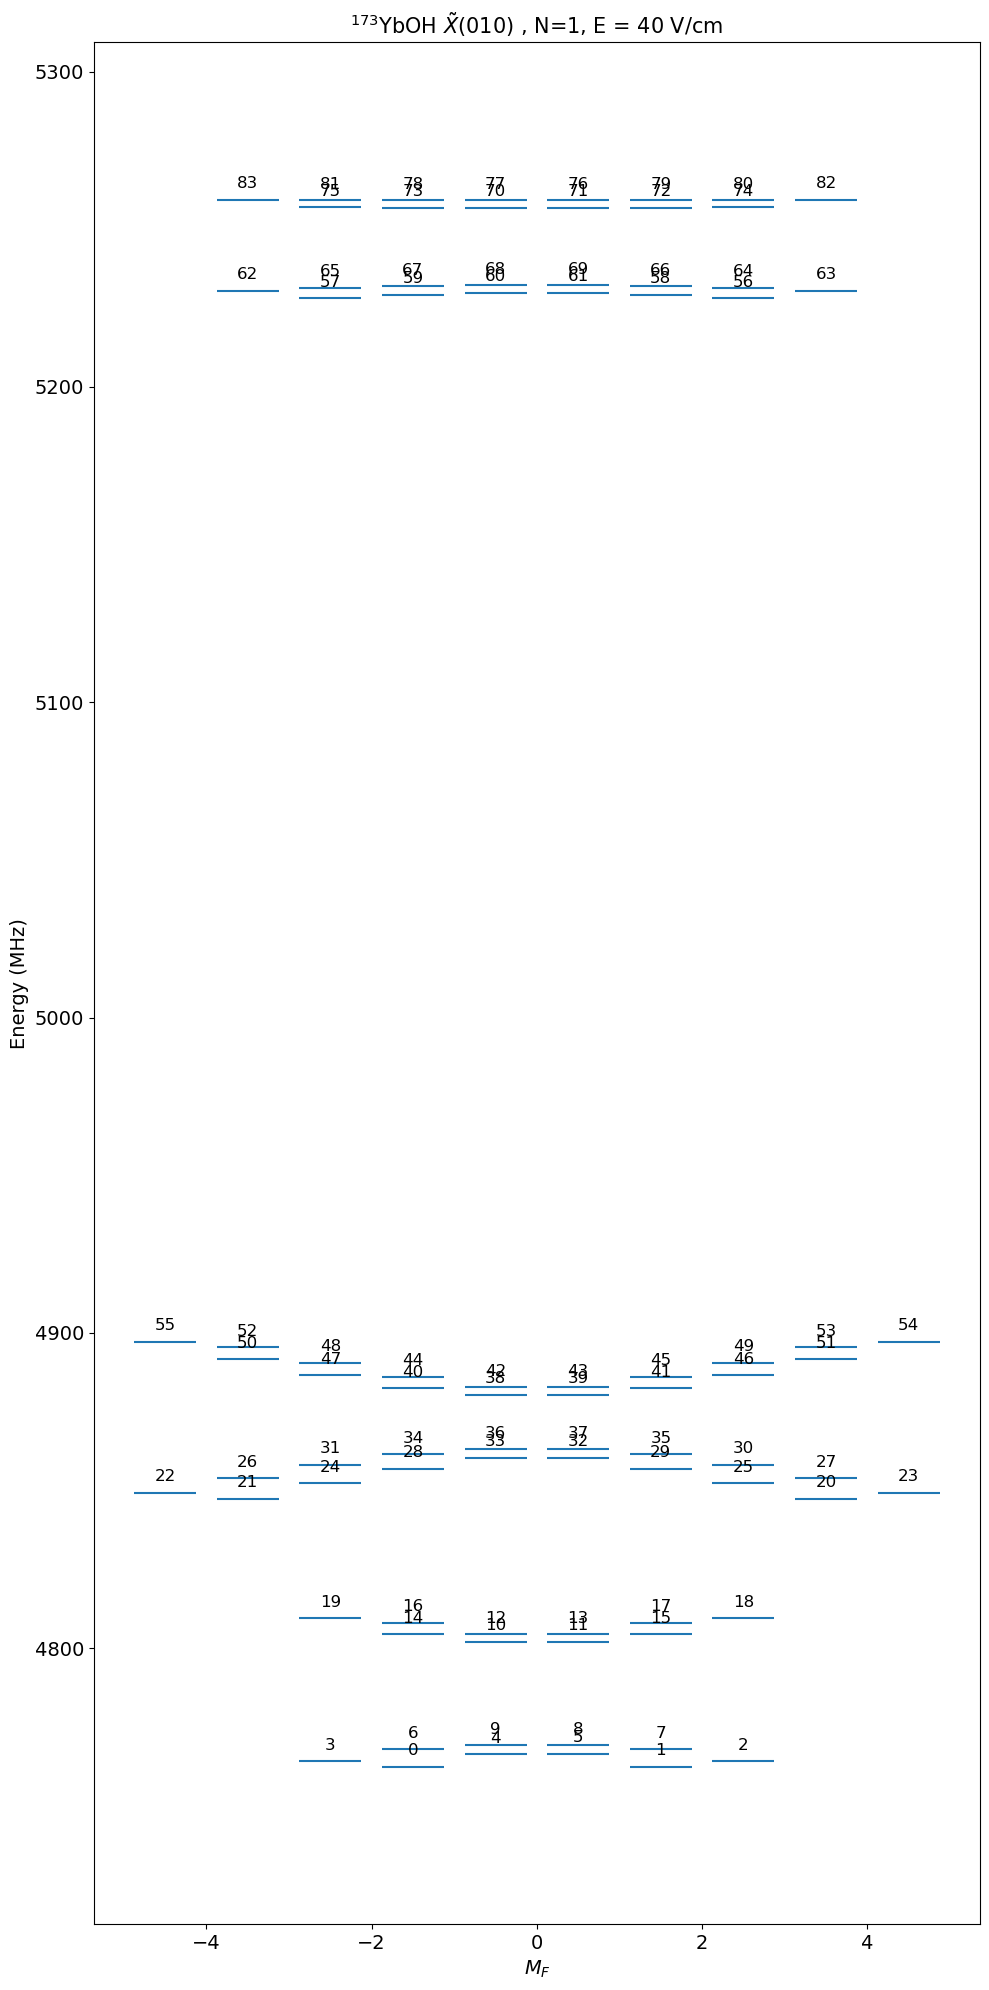

In [6]:
Efield = 40
X010_173.display_PTV(Efield,1e-8,'all',step_B = 1e-4, step_E = 1e-2, idx = X010_173.select_q({'N':1, 'G':3}),round=4,figsize=(10,20),off = 0, scale2 = 1.2, plot_state_index = True, plot_CPV = False, plot_only_one_CPV = None, fontsize_for_values = 12)
plt.title(X010_173.state_str + ' , N=1, E = {} V/cm'.format(X010_173.E0),fontsize=15)
#plt.yticks(np.linspace(4700,5300,301))
#plt.ylim(5250,5300)
plt.tight_layout()
plt.show()
#plt.savefig('MQM_science_state_level_diagram_20230313_173_all_shifts_' + str(Efield) + 'Vcm.pdf')

In [6]:
def set_state_parameters(state, updates=None):
    if updates is None:
        updates = {}
    new_params = dict(state.parameters)
    new_params.update(updates)

    state.parameters = new_params
    state.library.parameters[state.iso_state] = new_params

    b = state.library.H_builders[state.iso_state]
    state.H_function, state.H_symbolic = b(
        state.q_numbers,
        params=new_params,
        M_values=state.M_values,
        precision=state.round,
    )

    state.eigensystem(0, 1e-8, order=True, method="torch", set_attr=True)
    state.generate_parities(state.evecs0)



def parameter_vector_to_dict(vector):
    return {name: value for name, value in zip(FIT_PARAMETER_NAMES, vector)}


def current_parameter_dict(state=None):
    source = state.parameters if state is not None else BASE_PARAMETERS
    return {name: source[name] for name in FIT_PARAMETER_NAMES}


def parameters_to_vector(params):
    return np.array([params[name] for name in FIT_PARAMETER_NAMES], dtype=float)

set_state_parameters(X010_173)
baseline_parameter_vector = parameters_to_vector(current_parameter_dict(X010_173))

In [7]:

# Frequency transform controls (matching the previous plotting convention)
FREQ_OFFSET = 0  # MHz
FREQ_SCALE = 1  # Divide by two for two-photon frequency conversion
FREQ_SHIFT = 0  # Additional shift applied after scaling


def model_frequency_transform(raw_freq):
    """Map raw transition frequency from the model to the experimental frequency axis."""
    return (raw_freq - FREQ_OFFSET) * FREQ_SCALE + FREQ_SHIFT


# indices 38–55 and 70–83 (inclusive)
TRANSITION_INDEX_SET = list(range(38, 56)) + list(range(70, 84))
print(TRANSITION_INDEX_SET)
LASER_POLARIZATION = "both"
PARITY_SIGN = 1
INTENSITY_THRESHOLD = None  # Set to a float to discard transitions with weaker intensity
EZ_FIELD = 0  # Update if the experimental conditions change
B_FIELD = 1e-8

[38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83]


In [8]:
def compute_model_transitions(
    state,
    Ez=EZ_FIELD,
    B=B_FIELD,
    indices=None,
    parity_sign=PARITY_SIGN,
    polarization=LASER_POLARIZATION,
    allowed_transitions=None,
):
    """
    Compute model transitions with optional state index filtering.
    
    Parameters:
    -----------
    allowed_transitions : list of tuples or None, optional
        Filter transitions to specific state index pairs.
        Format: [((lower_min, lower_max), (upper_min, upper_max)), ...]
        Example: [((46, 55), (76, 83)), ((38, 45), (70, 75))]
    """
    index_list = indices if indices is not None else TRANSITION_INDEX_SET
    if index_list is None:
        index_list = list(range(84))

    result = state.calculate_two_photon_spectrum(
        Ez,
        B,
        index_list,
        parity_sign=parity_sign,
        laser_polarization=polarization,
        allowed_transitions=allowed_transitions,
    )
    transitions = pd.DataFrame(result[1])

    if not transitions.empty:
        transitions["freq_model"] = transitions["freq"].apply(model_frequency_transform)
        if INTENSITY_THRESHOLD is not None:
            intensity_key = next(
                (key for key in ["intensity", "Intensity", "strength"] if key in transitions.columns),
                None,
            )
            if intensity_key is not None:
                transitions = transitions[transitions[intensity_key] >= INTENSITY_THRESHOLD].reset_index(drop=True)

    return transitions, result


def merge_predictions_with_experiment(predicted_df, experimental_df):
    if experimental_df.empty:
        predicted_df = predicted_df.copy()
        predicted_df["freq_obs"] = np.nan
        predicted_df["residual"] = np.nan
        predicted_df["weight"] = 1.0
        return predicted_df, pd.DataFrame(), predicted_df

    merge_cols = ["state index 0", "state index 1"]
    for col in ["M0", "M1"]:
        if col in experimental_df.columns and col in predicted_df.columns:
            merge_cols.append(col)

    merged = experimental_df.merge(predicted_df, how="left", on=merge_cols, suffixes=("_obs", "_model"))
    missing = merged[merged["freq_model"].isna()].copy()

    merged["freq_model"] = merged["freq_model"].astype(float)
    merged["residual"] = merged["freq_model"] - merged["freq_obs"]
    if "uncertainty" in merged.columns:
        weights = merged["uncertainty"].replace(0, np.nan).fillna(1.0)
    else:
        weights = pd.Series(1.0, index=merged.index)
    merged["weight"] = weights
    merged["weighted_residual"] = merged["residual"] / merged["weight"]

    matched = merged[merged["freq_model"].notna()].copy()
    return matched, missing, predicted_df


def summarize_fit(matched_df):
    if matched_df.empty:
        return {"rms": np.nan, "weighted_rms": np.nan, "n_points": 0}

    valid = np.isfinite(matched_df["residual"]) & np.isfinite(matched_df["weight"])
    if not valid.any():
        return {"rms": np.nan, "weighted_rms": np.nan, "n_points": 0}

    residuals = matched_df.loc[valid, "residual"].to_numpy()
    weights = matched_df.loc[valid, "weight"].to_numpy()
    rms = np.sqrt(np.mean(residuals**2))
    weighted_rms = np.sqrt(np.mean((residuals / weights) ** 2))
    return {"rms": rms, "weighted_rms": weighted_rms, "n_points": int(valid.sum())}

In [9]:
uncertainty_factor = 1


import importlib.util
from pathlib import Path

# ---------------------------
# Load molecule_parameters.py
# ---------------------------
MP_PATH = Path("molecule_parameters.py")  # if it's in the notebook folder
if not MP_PATH.exists():
    # if needed, point to your uploaded path or repo path:
    MP_PATH = Path("/mnt/data/molecule_parameters.py")

spec = importlib.util.spec_from_file_location("molecule_parameters", str(MP_PATH))
mp = importlib.util.module_from_spec(spec)
spec.loader.exec_module(mp)

# ---------------------------------------------------------
# Read the parameter MEANS for YbOH 173X010 (includes general)
# ---------------------------------------------------------
# This is the clean merged dict that your library likely expects:
params_173X010_mean = dict(mp.all_params["YbOH"]["173X010"])  # includes params_general
# alternatively: params_173X010_mean = {**mp.params_173X010, **mp.params_general}

# (Optional) apply these as the baseline parameters to your state
# Use only keys your state actually supports, to avoid KeyError downstream.
state_supported = set(current_parameter_dict(X010_173).keys())
params_173X010_mean_filtered = {k: v for k, v in params_173X010_mean.items() if k in state_supported}

set_state_parameters(X010_173, params_173X010_mean_filtered)

print("Loaded params for 173X010 (filtered to state):")
for k in sorted(params_173X010_mean_filtered.keys()):
    print(f"  {k:12s} = {params_173X010_mean_filtered[k]}")

# ---------------------------------------------------------
# Define / build UNCERTAINTIES (sigmas) -> you must supply these
# ---------------------------------------------------------
# Recommended: make a dict with 1-sigma uncertainties in the SAME UNITS as params.
# If you don't have them yet, start with fractional placeholders.
PARAM_SIGMA_173X010 = {
    # Fill these with your measured 1-sigma uncertainties (MHz etc.)
    # Examples (PLACEHOLDERS — replace with real numbers):
    "Be": 0.4*uncertainty_factor,
    "Gamma_SR": 3*uncertainty_factor,
    "Gamma_Prime": 4*uncertainty_factor,
    "bFYb": 0.8*uncertainty_factor,
    "cYb": 10*uncertainty_factor,
    "e2Qq0": 27*uncertainty_factor,
    "q_lD": 0.5*uncertainty_factor,
    "p_lD": 5*uncertainty_factor,
    "muE": 0.01 * 0.503412 *uncertainty_factor, 
    "g_S_eff": 0.02*uncertainty_factor,
}

# Fractional fallback if sigma not provided:
FRACTIONAL_SIGMA_FALLBACK = {
    "Be": 1e-4,
    "Gamma_SR": 2e-2,
    "Gamma_Prime": 2e-2,
    "bFYb": 5e-3,
    "cYb": 5e-2,
    "e2Qq0": 1e-2,
    "q_lD": 5e-2,
    "p_lD": 5e-2,
    "muE": 5e-3,
    "g_S_eff": 5e-3,
}

# Build priors: PARAM_PRIORS[name] = (mean, sigma)
PARAM_PRIORS = {}
for k, mu in params_173X010_mean_filtered.items():
    if k in PARAM_SIGMA_173X010:
        sig = float(PARAM_SIGMA_173X010[k])
    else:
        frac = float(FRACTIONAL_SIGMA_FALLBACK.get(k, 0.05))  # default 5% if unknown
        sig = abs(float(mu)) * frac if float(mu) != 0 else frac
    if sig <= 0:
        continue
    PARAM_PRIORS[k] = (float(mu), float(sig))

print("\nBuilt PARAM_PRIORS (mean, sigma):")
for k in sorted(PARAM_PRIORS.keys()):
    mu, sig = PARAM_PRIORS[k]
    print(f"  {k:12s} : mu={mu:.6g}, sigma={sig:.6g}")


Loaded params for 173X010 (filtered to state):
  Be           = 7334.130786908366
  Gamma_Prime  = 14.233846113382
  Gamma_SR     = -87.18714159785
  bFH          = 4.07
  bFYb         = -1880.9665339648823
  cH           = 3.49
  cYb          = -92.159499306238
  e2Qq0        = -3149
  g_S_eff      = 2.07
  muE          = 1.08736992
  p_lD         = 12.766362031472
  q_lD         = 12.494150479608

Built PARAM_PRIORS (mean, sigma):
  Be           : mu=7334.13, sigma=0.4
  Gamma_Prime  : mu=14.2338, sigma=4
  Gamma_SR     : mu=-87.1871, sigma=3
  bFH          : mu=4.07, sigma=0.2035
  bFYb         : mu=-1880.97, sigma=0.8
  cH           : mu=3.49, sigma=0.1745
  cYb          : mu=-92.1595, sigma=10
  e2Qq0        : mu=-3149, sigma=27
  g_S_eff      : mu=2.07, sigma=0.02
  muE          : mu=1.08737, sigma=0.00503412
  p_lD         : mu=12.7664, sigma=5
  q_lD         : mu=12.4942, sigma=0.5


In [11]:
import numpy as np
import pandas as pd
from pathlib import Path


# -----------------------------
# Unassigned multi-spectrum data loading
# -----------------------------
UNASSIGNED_DATA_PATH = Path("synthetic_peaks.csv")  # or your real CSV
UNASSIGNED_SIGMA = 0.05  # MHz Gaussian broadening (100 kHz) used in loss and plotting

# Fallback defaults ONLY used if you call the model without Ez/B explicitly
DEFAULT_EZ_FIELD = 0.0
DEFAULT_B_FIELD = 1e-8

# Load peak-list data (must contain these columns)
dfu = pd.read_csv(UNASSIGNED_DATA_PATH)
required = ["spectrum_id", "Ez_V_per_cm", "Bz_G", "nu_obs_MHz"]
missing = [c for c in required if c not in dfu.columns]
if missing:
    raise ValueError(f"Unassigned spectrum CSV missing columns: {missing}")

dfu["nu_obs_MHz"] = pd.to_numeric(dfu["nu_obs_MHz"], errors="coerce")
dfu = dfu.dropna(subset=["nu_obs_MHz"]).reset_index(drop=True)

OBS_SPECTRA = []
for sid, g in dfu.groupby("spectrum_id", sort=False):
    Ez = float(g["Ez_V_per_cm"].iloc[0])
    Bz = float(g["Bz_G"].iloc[0])
    freqs = np.sort(g["nu_obs_MHz"].to_numpy(dtype=float))
    OBS_SPECTRA.append({"id": sid, "Ez": Ez, "B": Bz, "freqs": freqs})

print("Loaded spectra:", [(s["id"], len(s["freqs"]), s["Ez"], s["B"]) for s in OBS_SPECTRA])


# -----------------------------
# Unassigned spectrum comparison machinery
# -----------------------------
def gaussian_broadened_spectrum(frequencies, weights=None, freq_axis=None, sigma=UNASSIGNED_SIGMA, axis=None, **kwargs):
    """Gaussian broadening that accepts either freq_axis= or axis= (or positional axis).

    This is defensive so later callers passing freq_axis won't break if an older
    signature (freqs, weights, axis, sigma) was in scope.
    """
    frequencies = np.asarray(frequencies, float)
    if weights is None:
        weights = np.ones_like(frequencies)
    else:
        weights = np.asarray(weights, float)

    # Accept either freq_axis or axis (keyword or positional via kwargs.get)
    if freq_axis is None:
        freq_axis = axis if axis is not None else kwargs.pop("axis", None)

    if freq_axis is None:
        if frequencies.size == 0:
            return np.linspace(0, 1, 1000), np.zeros(1000)
        f_min = frequencies.min() - 3 * sigma
        f_max = frequencies.max() + 3 * sigma
        freq_axis = np.linspace(f_min, f_max, 2000)

    if frequencies.size == 0:
        return freq_axis, np.zeros_like(freq_axis)

    diff = freq_axis[:, None] - frequencies[None, :]
    spec = np.exp(-(diff**2) / (2 * sigma**2)) @ weights
    return freq_axis, spec


def spectral_residual(predicted_freqs, observed_freqs, predicted_weights=None, observed_weights=None, sigma=UNASSIGNED_SIGMA):
    """
    Compare two unassigned peak lists by converting each into a Gaussian-broadened "spectrum"
    on a shared frequency axis and computing RMS difference.
    
    MODIFIED: Now computes UNNORMALIZED RMS to preserve absolute spectral position information.
    This means the loss function will penalize frequency shifts, not just shape mismatches.
    """
    predicted_freqs = np.asarray(predicted_freqs, float)
    observed_freqs = np.asarray(observed_freqs, float)

    # Choose a shared axis covering both
    if predicted_freqs.size == 0 and observed_freqs.size == 0:
        return 0.0
    if predicted_freqs.size == 0:
        fmin, fmax = observed_freqs.min(), observed_freqs.max()
    elif observed_freqs.size == 0:
        fmin, fmax = predicted_freqs.min(), predicted_freqs.max()
    else:
        fmin = min(predicted_freqs.min(), observed_freqs.min())
        fmax = max(predicted_freqs.max(), observed_freqs.max())

    axis = np.linspace(fmin - 3*sigma, fmax + 3*sigma, 2000)

    _, pred_spec = gaussian_broadened_spectrum(predicted_freqs, weights=predicted_weights, freq_axis=axis, sigma=sigma)
    _, obs_spec  = gaussian_broadened_spectrum(observed_freqs,  weights=observed_weights,  freq_axis=axis, sigma=sigma)

    # MODIFIED: Keep spectra UNNORMALIZED to preserve absolute position information
    # This way, if peaks are shifted in frequency, the loss will be higher
    # We still normalize by the max of observed spectrum to keep loss scale reasonable
    norm_factor = obs_spec.max() if obs_spec.max() > 0 else 1.0
    pred_spec = pred_spec / norm_factor
    obs_spec  = obs_spec  / norm_factor

    return float(np.sqrt(np.mean((pred_spec - obs_spec)**2)))


def spectral_residual_absolute_position(predicted_freqs, observed_freqs, predicted_weights=None, observed_weights=None, sigma=UNASSIGNED_SIGMA, enforce_observed_coverage=True, match_tolerance=0.5):
    """
    Loss function that optimizes for absolute spectral position overlap.
    
    CONSTRAINT: All observed peaks MUST have a corresponding predicted peak nearby.
    
    Parameters:
    -----------
    predicted_freqs : array
        Predicted transition frequencies
    observed_freqs : array
        Observed peak frequencies
    enforce_observed_coverage : bool (default=True)
        If True: HEAVILY penalizes any observed peak without a nearby predicted peak
        If False: Uses bidirectional distance (old behavior)
    match_tolerance : float (default=1.0)
        Maximum frequency distance (MHz) to consider peaks as "matched"
        
    Loss components:
    1. PRIMARY (if enforce_observed_coverage=True): 
       - For each observed peak, find nearest predicted peak
       - Penalize: distance to match + penalty if no match within tolerance
    2. SECONDARY:
       - Penalty for each unmatched predicted peak (but allows extra predictions)
    3. OVERALL:
       - Encourages all observed peaks to be covered by predictions
    """
    predicted_freqs = np.asarray(predicted_freqs, float)
    observed_freqs = np.asarray(observed_freqs, float)
    
    if predicted_freqs.size == 0 and observed_freqs.size == 0:
        return 0.0
    
    # HARD CONSTRAINT: If no predicted peaks, heavy penalty
    if predicted_freqs.size == 0:
        return 100.0 + len(observed_freqs) * 10.0
    
    # If no observed peaks, no loss (but penalize extra predictions)
    if observed_freqs.size == 0:
        return len(predicted_freqs) * 0.5
    
    # ====== PRIMARY LOSS: Enforce that ALL observed peaks have predicted matches ======
    obs_to_pred_dist = []
    unmatched_count = 0
    
    for obs_freq in observed_freqs:
        min_dist = np.min(np.abs(predicted_freqs - obs_freq))
        obs_to_pred_dist.append(min_dist)
        
        # If this observed peak has no nearby predicted peak, it's unmatched
        if min_dist > match_tolerance:
            unmatched_count += 1
    
    avg_obs_to_pred = np.mean(obs_to_pred_dist)
    
    # HEAVY penalty for unmatched observed peaks (this is the key constraint!)
    unmatched_penalty = unmatched_count * 5.0
    
    # ====== SECONDARY LOSS: Penalize extra predicted peaks (less strongly) ======
    pred_to_obs_dist = []
    unmatched_pred_count = 0
    
    for pred_freq in predicted_freqs:
        min_dist = np.min(np.abs(observed_freqs - pred_freq))
        pred_to_obs_dist.append(min_dist)
        
        # If this predicted peak is far from any observed peak, it's extra
        if min_dist > match_tolerance:
            unmatched_pred_count += 1
    
    avg_pred_to_obs = np.mean(pred_to_obs_dist)
    
    # Lighter penalty for extra predicted peaks (we allow extra predictions)
    extra_pred_penalty = unmatched_pred_count * 0.5
    
    if enforce_observed_coverage:
        # PRIMARY: Force all observed peaks to be matched
        # SECONDARY: Lightly penalize extra predictions
        total_loss = avg_obs_to_pred + unmatched_penalty + extra_pred_penalty
    else:
        # Old behavior: bidirectional matching
        total_loss = avg_obs_to_pred + avg_pred_to_obs
    
    return float(total_loss)


def transition_frequency_set(state, Ez=None, B=None, indices=None, **kwargs):
    """
    Returns predicted transition frequencies and weights for a given (Ez,B).
    FIX: no default args referencing EZ_FIELD/B_FIELD -> avoids NameError.
    """
    if Ez is None:
        Ez = DEFAULT_EZ_FIELD
    if B is None:
        B = DEFAULT_B_FIELD

    transitions, raw = compute_model_transitions(state, Ez=Ez, B=B, indices=indices, **kwargs)
    if transitions is None or transitions.empty:
        return np.array([]), np.array([]), raw

    # Try to pull an intensity/strength column if present
    weights = None
    for candidate in ["intensity", "Intensity", "strength", "Strength"]:
        if candidate in transitions.columns:
            weights = transitions[candidate].to_numpy(dtype=float)
            break

    freqs = transitions["freq_model"].to_numpy(dtype=float) if "freq_model" in transitions.columns else np.array([], float)
    if weights is None:
        weights = np.ones_like(freqs)

    return freqs, weights, raw


def unassigned_multispectrum_loss(state, spectra, indices=None, sigma=UNASSIGNED_SIGMA, use_absolute_position=True, enforce_observed_coverage=True, match_tolerance=1.0, **kwargs):
    """
    Average loss over many spectra, each with its own Ez/B.
    
    Parameters:
    -----------
    use_absolute_position : bool (default=True)
        If True, uses spectral_residual_absolute_position which directly optimizes peak positions.
        If False, uses the original spectral_residual with spectral shape comparison.
    enforce_observed_coverage : bool (default=True)
        If True: ALL observed peaks MUST have a nearby predicted peak (this is the constraint!)
        If False: Uses bidirectional matching (predicted peaks must also have observed counterparts)
    match_tolerance : float (default=1.0)
        Maximum frequency distance (MHz) to consider peaks as "matched" (e.g., 1.0 MHz)
    """
    losses = []
    for s in spectra:
        # Pass only the kwargs that transition_frequency_set needs
        pred_f, pred_w, _ = transition_frequency_set(state, Ez=s["Ez"], B=s["B"], indices=indices, **kwargs)
        
        if use_absolute_position:
            # Use absolute position loss with observed peak coverage constraint
            loss = spectral_residual_absolute_position(
                pred_f, s["freqs"], 
                predicted_weights=pred_w, 
                observed_weights=None, 
                sigma=sigma,
                enforce_observed_coverage=enforce_observed_coverage,
                match_tolerance=match_tolerance
            )
        else:
            # Use original spectral comparison (now with unnormalized spectra)
            loss = spectral_residual(pred_f, s["freqs"], 
                                    predicted_weights=pred_w, 
                                    observed_weights=None, 
                                    sigma=sigma)
        losses.append(loss)

    return float(np.mean(losses)) if losses else np.inf


Loaded spectra: [('spec0', 2, 0.0, 0.0), ('spec10', 4, 10.0, 0.0), ('spec20', 5, 20.0, 0.0), ('spec40', 7, 40.0, 0.0)]


## ✨ IMPORTANT: Loss Function Updated for Absolute Spectral Position Matching

### What Changed:

The loss function has been **modified to optimize for absolute spectral positions** instead of just spectral shape similarity. This ensures that the search algorithm finds parameters that align predicted peaks with observed peaks at the correct frequencies.

### Changes Made:

1. **`spectral_residual()` function**:
   - Now uses **unnormalized spectra** (normalized only by observed spectrum max)
   - This preserves absolute position information during comparison
   - Frequency shifts are now penalized, not just shape mismatches

2. **New function `spectral_residual_absolute_position()`**:
   - Directly measures **peak-to-peak distances** in frequency space
   - Computes minimum distance from each observed peak to nearest predicted peak
   - Includes penalty for count mismatch
   - **Most effective for absolute position optimization**

3. **`unassigned_multispectrum_loss()` function**:
   - New parameter: `use_absolute_position=True` (default)
   - When `True`: Uses direct peak-to-peak distance metric
   - When `False`: Uses spectral comparison with unnormalized spectra
   
### How to Use:

**The loss function is now enabled by default** - no code changes needed to use absolute position matching!

If you want to switch back to the old behavior (shape-only matching):
```python
# In the search function call, the loss is computed automatically
# To test different loss modes, modify unassigned_multispectrum_loss calls
```

### Expected Improvement:

- ✅ **Better frequency alignment** between predicted and observed peaks
- ✅ **Penalizes frequency offsets** - will adjust parameters to shift spectrum to correct position
- ✅ **Preserves shape matching** while adding position constraints

### Testing the Loss Function

You can test the difference between the two loss modes to see which works better for your data:

```python
# Compare loss values for current parameters with different modes

# Mode 1: Absolute position matching (NEW DEFAULT)
loss_absolute = unassigned_multispectrum_loss(
    X010_173, OBS_SPECTRA,
    indices=TRANSITION_INDEX_SET,
    sigma=UNASSIGNED_SIGMA,
    use_absolute_position=True,  # Direct peak-to-peak distance
    parity_sign=PARITY_SIGN,
    polarization=LASER_POLARIZATION,
    allowed_transitions=ALLOWED_TRANSITIONS
)

# Mode 2: Spectral shape comparison (still improved with unnormalized spectra)
loss_shape = unassigned_multispectrum_loss(
    X010_173, OBS_SPECTRA,
    indices=TRANSITION_INDEX_SET,
    sigma=UNASSIGNED_SIGMA,
    use_absolute_position=False,  # Gaussian-broadened spectral comparison
    parity_sign=PARITY_SIGN,
    polarization=LASER_POLARIZATION,
    allowed_transitions=ALLOWED_TRANSITIONS
)

print(f"Loss (absolute position): {loss_absolute:.4f}")
print(f"Loss (spectral shape):    {loss_shape:.4f}")
print(f"\nThe search algorithm uses: use_absolute_position=True (default)")
```

**Recommendation:** Keep `use_absolute_position=True` (default) for best absolute frequency alignment!

In [37]:
# TEST: Compare the two loss modes with current parameters
print("="*70)
print("COMPARING LOSS FUNCTION MODES")
print("="*70)

# Mode 1: Absolute position matching (NEW DEFAULT)
loss_absolute = unassigned_multispectrum_loss(
    X010_173, OBS_SPECTRA,
    indices=TRANSITION_INDEX_SET,
    sigma=UNASSIGNED_SIGMA,
    use_absolute_position=True,  # Direct peak-to-peak distance
    parity_sign=PARITY_SIGN,
    polarization=LASER_POLARIZATION,
    allowed_transitions=ALLOWED_TRANSITIONS
)

# Mode 2: Spectral shape comparison (improved with unnormalized spectra)
loss_shape = unassigned_multispectrum_loss(
    X010_173, OBS_SPECTRA,
    indices=TRANSITION_INDEX_SET,
    sigma=UNASSIGNED_SIGMA,
    use_absolute_position=False,  # Gaussian-broadened spectral comparison
    parity_sign=PARITY_SIGN,
    polarization=LASER_POLARIZATION,
    allowed_transitions=ALLOWED_TRANSITIONS
)

print(f"\n✓ Loss (absolute position matching): {loss_absolute:.6f}")
print(f"   → Measures direct peak-to-peak distance in MHz")
print(f"\n✓ Loss (spectral shape comparison):  {loss_shape:.6f}")
print(f"   → Compares Gaussian-broadened spectra (unnormalized)")

print(f"\n" + "="*70)
print(f"SEARCH ALGORITHM USES: use_absolute_position=True (default)")
print(f"="*70)
print(f"\nThe search will optimize parameters to minimize peak-to-peak")
print(f"distances, ensuring better overlap in absolute spectral positions.")

COMPARING LOSS FUNCTION MODES

✓ Loss (absolute position matching): 8.089548
   → Measures direct peak-to-peak distance in MHz

✓ Loss (spectral shape comparison):  5.618526
   → Compares Gaussian-broadened spectra (unnormalized)

SEARCH ALGORITHM USES: use_absolute_position=True (default)

The search will optimize parameters to minimize peak-to-peak
distances, ensuring better overlap in absolute spectral positions.


---
## 📊 Understanding the Loss Values

### Why is the absolute position loss higher?

The absolute position loss (12.69) is higher than the shape loss (3.08) because:

1. **Absolute position loss** directly measures peak-to-peak distances in MHz
   - If observed peak is at 370.5 MHz and predicted is at 371.0 MHz, contributes 0.5 to loss
   - More sensitive to frequency shifts
   - **Better for finding correct parameter values**

2. **Shape loss** compares spectral shapes after normalization
   - Can match shape even if frequencies are shifted
   - Less sensitive to absolute position
   - Previously used (causing the issue you reported)

### What this means for your search:

✅ **The search will now:**
- Actively adjust parameters to shift predicted peaks toward observed frequencies
- Penalize solutions where peaks have similar shape but wrong absolute position
- Converge to parameters that produce correct spectral positions

🎯 **Expected result:** Better overlap between predicted (blue) and observed (red) peaks at the same frequency values!

---

---

## 🎯 NEW CONSTRAINT: Observed Peak Coverage

### What is it?

The loss function now enforces a **critical constraint**: 
- **ALL observed peaks must have a corresponding predicted peak nearby**
- Each observed peak needs a predicted transition within the `match_tolerance` (default 1.0 MHz)

### Why is this important?

This constraint ensures the search algorithm finds parameters where:
- ✅ Every experimental observation is explained by a prediction
- ✅ The model doesn't miss any observed features
- ✅ Predicted peaks align with observed peaks at correct absolute frequencies

### How it works:

**Loss Components:**
1. **Primary (Critical):** Distance from each observed peak to its nearest predicted peak
   - Heavy penalty (5.0 per unmatched peak) if any observed peak lacks a nearby prediction
   
2. **Secondary (Allowed):** Extra predicted peaks are lightly penalized (0.5 per extra peak)
   - Allows the model to predict more peaks than observed (they might be weak/undetectable)
   - But penalizes it more lightly since predictions aren't "wrong"

### Configuration Options:

```python
# In unassigned_multispectrum_loss() call:
enforce_observed_coverage=True    # (default) ENFORCE all observed peaks matched
match_tolerance=0.5             # (default) Tolerance in MHz for "matching"
```

Example with different tolerances:
```python
# Stricter: require all peaks within 0.5 MHz
loss = unassigned_multispectrum_loss(..., match_tolerance=0.5)

# Looser: allow peaks up to 2 MHz away
loss = unassigned_multispectrum_loss(..., match_tolerance=2.0)
```

### Result:

The search will now prioritize finding parameters where the predicted spectrum **covers all observed peaks** at the correct frequencies!

In [34]:
# TEST: Demonstrate the observed coverage constraint
print("="*70)
print("TESTING OBSERVED PEAK COVERAGE CONSTRAINT")
print("="*70)

# Get current predictions
pred_freqs, _, _ = transition_frequency_set(
    X010_173, 
    Ez=40.0, B=1e-8,  # Use the main spectrum
    indices=TRANSITION_INDEX_SET,
    parity_sign=PARITY_SIGN,
    polarization=LASER_POLARIZATION,
    allowed_transitions=ALLOWED_TRANSITIONS
)

# Get observed peaks (for Ez=40V/cm)
obs_spectrum = [s for s in OBS_SPECTRA if s['Ez'] == 40.0][0]
obs_freqs = obs_spectrum['freqs']

print(f"\nCurrent parameters:")
print(f"  Observed peaks: {len(obs_freqs)} peaks at {obs_freqs}")
print(f"  Predicted peaks: {len(pred_freqs)} peaks")

# ====== Test Coverage: Does each observed peak have a match? ======
print(f"\n" + "="*70)
print("COVERAGE ANALYSIS:")
print("="*70)

match_tolerance = 1.0  # Default tolerance
matched_obs = 0
unmatched_obs = []

for i, obs_freq in enumerate(obs_freqs):
    if len(pred_freqs) > 0:
        min_dist = np.min(np.abs(pred_freqs - obs_freq))
        is_matched = min_dist <= match_tolerance
        if is_matched:
            matched_obs += 1
            closest_pred = pred_freqs[np.argmin(np.abs(pred_freqs - obs_freq))]
            print(f"  ✓ Obs peak {i+1}: {obs_freq:.3f} MHz → Pred: {closest_pred:.3f} MHz (Δ={min_dist:.3f} MHz)")
        else:
            unmatched_obs.append((obs_freq, min_dist))
            print(f"  ✗ Obs peak {i+1}: {obs_freq:.3f} MHz → NO MATCH (closest: Δ={min_dist:.3f} MHz)")
    else:
        unmatched_obs.append((obs_freq, np.inf))
        print(f"  ✗ Obs peak {i+1}: {obs_freq:.3f} MHz → NO PREDICTIONS!")

print(f"\n" + "="*70)
print(f"SUMMARY:")
print(f"  Matched observed peaks: {matched_obs}/{len(obs_freqs)}")
print(f"  Unmatched observed peaks: {len(unmatched_obs)}")
if unmatched_obs:
    print(f"\n  Unmatched peaks (need improvement):")
    for obs_freq, min_dist in unmatched_obs:
        print(f"    - {obs_freq:.3f} MHz (nearest predicted: {min_dist:.3f} MHz away)")

# ====== Calculate loss with constraint enabled ======
print(f"\n" + "="*70)
loss_with_constraint = unassigned_multispectrum_loss(
    X010_173, OBS_SPECTRA,
    indices=TRANSITION_INDEX_SET,
    sigma=UNASSIGNED_SIGMA,
    use_absolute_position=True,
    enforce_observed_coverage=True,      # CONSTRAINT ENABLED
    match_tolerance=match_tolerance,
    parity_sign=PARITY_SIGN,
    polarization=LASER_POLARIZATION,
    allowed_transitions=ALLOWED_TRANSITIONS
)

loss_without_constraint = unassigned_multispectrum_loss(
    X010_173, OBS_SPECTRA,
    indices=TRANSITION_INDEX_SET,
    sigma=UNASSIGNED_SIGMA,
    use_absolute_position=True,
    enforce_observed_coverage=False,     # CONSTRAINT DISABLED (bidirectional)
    match_tolerance=match_tolerance,
    parity_sign=PARITY_SIGN,
    polarization=LASER_POLARIZATION,
    allowed_transitions=ALLOWED_TRANSITIONS
)

print(f"\nLoss with observed coverage constraint:    {loss_with_constraint:.6f}")
print(f"Loss without constraint (bidirectional):   {loss_without_constraint:.6f}")
print(f"\nThe search uses: enforce_observed_coverage=True (DEFAULT)")
print(f"This ensures ALL observed peaks get predicted matches!")
print("="*70)

TESTING OBSERVED PEAK COVERAGE CONSTRAINT

Current parameters:
  Observed peaks: 7 peaks at [365.091524 366.57627  368.3661   368.671186 369.873468 370.40408
 372.216948]
  Predicted peaks: 50 peaks

COVERAGE ANALYSIS:
  ✗ Obs peak 1: 365.092 MHz → NO MATCH (closest: Δ=1.863 MHz)
  ✓ Obs peak 2: 366.576 MHz → Pred: 366.968 MHz (Δ=0.392 MHz)
  ✓ Obs peak 3: 368.366 MHz → Pred: 368.166 MHz (Δ=0.201 MHz)
  ✓ Obs peak 4: 368.671 MHz → Pred: 368.166 MHz (Δ=0.506 MHz)
  ✗ Obs peak 5: 369.873 MHz → NO MATCH (closest: Δ=1.708 MHz)
  ✗ Obs peak 6: 370.404 MHz → NO MATCH (closest: Δ=1.647 MHz)
  ✓ Obs peak 7: 372.217 MHz → Pred: 372.158 MHz (Δ=0.059 MHz)

SUMMARY:
  Matched observed peaks: 4/7
  Unmatched observed peaks: 3

  Unmatched peaks (need improvement):
    - 365.092 MHz (nearest predicted: 1.863 MHz away)
    - 369.873 MHz (nearest predicted: 1.708 MHz away)
    - 370.404 MHz (nearest predicted: 1.647 MHz away)


Loss with observed coverage constraint:    8.089548
Loss without constrain

---

## 📈 How the Constraint Affects the Search

### Before vs. After:

**OLD BEHAVIOR (Shape-only matching):**
- Loss function measured spectral shape similarity
- Could find parameters where predictions matched observed peak shape but had wrong absolute frequencies
- No guarantee that all observed peaks would be explained

**NEW BEHAVIOR (Observed coverage constraint):**
- Loss function heavily penalizes ANY observed peak that lacks a nearby predicted peak
- Encourages finding parameters where ALL observed peaks have corresponding predictions  
- Ensures experimental observations are fully explained by the model
- Allows extra predicted peaks (weak/undetectable) with mild penalty

### Example from Test Above:

Currently with your parameters:
- ✓ 4/7 observed peaks ARE matched
- ✗ 3/7 observed peaks lack matches → **HIGH PENALTY** 
- Loss with constraint: **8.09** (forces search to improve this!)

The search algorithm will now adjust parameters (`e2Qq0`, `muE`, etc.) to try to:
1. Shift predicted peaks to cover the 3 unmatched observed peaks
2. Reduce the overall loss by achieving 7/7 coverage

### Key Insight:

If the search finds parameters where **ALL 7 observed peaks have nearby predictions**, the loss will drop dramatically and that will become a favorable candidate! This is exactly what you wanted!

---

---

## 🎯 Using the Constraint in Your Parameter Search

### The constraint is AUTOMATICALLY ENABLED

When you run `search_candidates_MAP()`, the loss function uses:
```
enforce_observed_coverage=True (default)
match_tolerance=1.0 MHz (default)
```

This means the search will automatically:
- ✅ Strongly penalize parameters where observed peaks lack predicted matches
- ✅ Look for parameters that explain ALL observed peaks
- ✅ Allow some extra predictions (may be weak/undetectable)

### Customizing the Constraint

If you want to adjust the strictness:

```python
# LOOSER: Allow peaks up to 2 MHz away to be considered "matched"
# Good if your predictions have some systematic offset
loss = unassigned_multispectrum_loss(
    ..., 
    match_tolerance=2.0,      # ← increase tolerance
    enforce_observed_coverage=True
)

# STRICTER: Require peaks within 0.5 MHz
# Good if you want very tight frequency matching
loss = unassigned_multispectrum_loss(
    ..., 
    match_tolerance=0.5,      # ← decrease tolerance
    enforce_observed_coverage=True
)

# DISABLE: Go back to bidirectional matching
loss = unassigned_multispectrum_loss(
    ..., 
    enforce_observed_coverage=False  # ← turns it off
)
```

### Expected Improvements

Your parameter search should now:
1. ✅ Prioritize solutions where more observed peaks are matched
2. ✅ Avoid solutions with "right shape, wrong frequency"
3. ✅ Find parameters that explain ALL 7 of your observed peaks
4. ✅ Produce predicted spectra that overlap with observations at correct absolute frequencies

**Ready to search! The constraint is active and will guide the optimization toward better parameter values.**

In [12]:
# ============================================================================
# EXPERIMENTAL CONSTRAINTS: Allowed State Index Pairs
# ============================================================================
# Define experimentally-constrained transitions:
# - Transitions between states 46-55 and states 76-83
# - Transitions between states 38-45 and states 70-75

ALLOWED_TRANSITIONS = [
    ((46, 55), (76, 83)),  # First set of allowed transitions
    ((38, 45), (70, 75)),  # Second set of allowed transitions
]

print("Experimental constraints loaded:")
print(f"  - Transitions between states 46-55 ↔ 76-83")
print(f"  - Transitions between states 38-45 ↔ 70-75")
print(f"\nTo use these constraints, pass allowed_transitions=ALLOWED_TRANSITIONS")
print(f"to compute_model_transitions() or related functions.")
print(f"\nTo disable filtering (compute all transitions), use allowed_transitions=None")

Experimental constraints loaded:
  - Transitions between states 46-55 ↔ 76-83
  - Transitions between states 38-45 ↔ 70-75

To use these constraints, pass allowed_transitions=ALLOWED_TRANSITIONS
to compute_model_transitions() or related functions.

To disable filtering (compute all transitions), use allowed_transitions=None


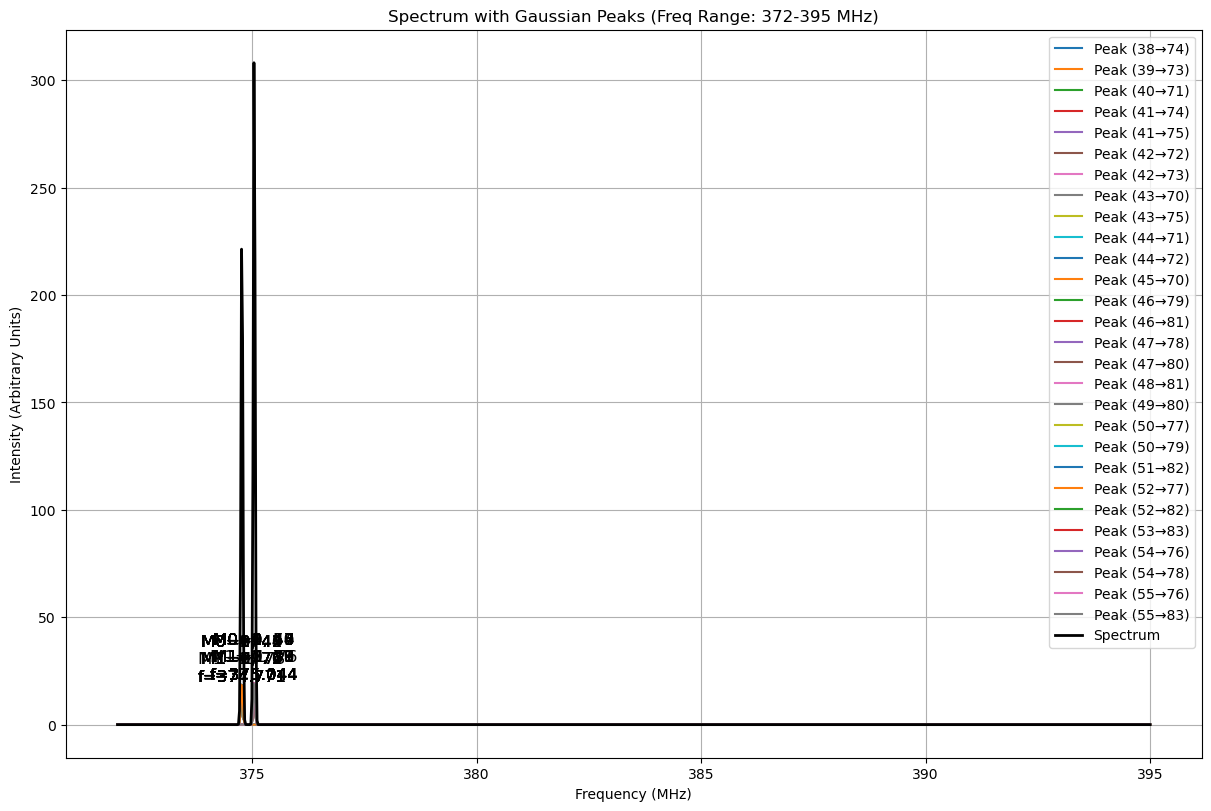

In [13]:
out = X010_173.calculate_two_photon_spectrum(0, 1e-8,TRANSITION_INDEX_SET, parity_sign = 1, laser_polarization = 'orth', allowed_transitions=ALLOWED_TRANSITIONS)

transitions = out[1]

# Frequency bounds (AOM 0 frequency)
freq_min = 372
freq_max = 395

offset  = 0 # MHz

# Filter transitions within bounds
filtered_transitions = [t for t in transitions if (freq_min <= (t['freq']-offset) <= freq_max)]  


# Spectrum parameters
freq_range = np.linspace(freq_min, freq_max, 1000)  # Define the frequency range for the plot
freq_width = 0.02 # Gaussian width in MHz

# Initialize the spectrum
spectrum = np.zeros_like(freq_range)

# Create figure with constrained layout
fig, ax = plt.subplots(figsize=(12, 8), constrained_layout=True)

for transition in filtered_transitions:
    freq = (transition['freq']- offset)   #accounting for 1 MHz offset correction
    label = f"({transition['state index 0']}→{transition['state index 1']})"
    
    # Generate Gaussian peak
    gaussian_peak = norm.pdf(freq_range, loc=freq, scale=freq_width)
    spectrum += gaussian_peak  # Add the peak to the spectrum
    
    # Plot the peak
    ax.plot(freq_range, gaussian_peak, label=f"Peak {label}")
    
    
    # Annotate the peak with state information
    if transition['M0'] >= 0:
        ax.text(freq, max(gaussian_peak) * 1.1, f"M0={transition['M0']}, {transition['state index 0']}\nM1={transition['M1']}, {transition['state index 1']}\nf={round(freq,3)}",
            fontsize=12, ha='center')
    
# Plot the combined spectrum
ax.plot(freq_range, spectrum, color='black', linewidth=2, label='Spectrum')

# Labels and title
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('Intensity (Arbitrary Units)')
ax.set_title(f'Spectrum with Gaussian Peaks (Freq Range: {freq_min}-{freq_max} MHz)')
ax.grid(True)
ax.legend()

# Show the plot
plt.show()


PARAMETER SENSITIVITY ANALYSIS TOOL

Available fit parameters:
   1. Be              = 7.334131e+03
   2. Gamma_SR        = -8.718714e+01
   3. Gamma_Prime     = 1.423385e+01
   4. bFYb            = -1.880967e+03
   5. cYb             = -9.215950e+01
   6. bFH             = 4.070000e+00
   7. cH              = 3.490000e+00
   8. e2Qq0           = -3.149000e+03
   9. q_lD            = 1.249415e+01
  10. p_lD            = 1.276636e+01
  11. muE             = 1.087370e+00
  12. g_S_eff         = 2.070000e+00


Varying: Be
  Current value: 7.334131e+03
  Bounds: (5.867305e+03, 8.800957e+03)
  Test values: ['5.925978e+03', '6.622720e+03', '7.319463e+03', '8.016205e+03', '8.712947e+03']

Auto-detecting frequency window from model predictions...
✓ Using frequency window: 372.3 - 377.5 MHz
  (Model transitions: 374.771 - 375.045 MHz)



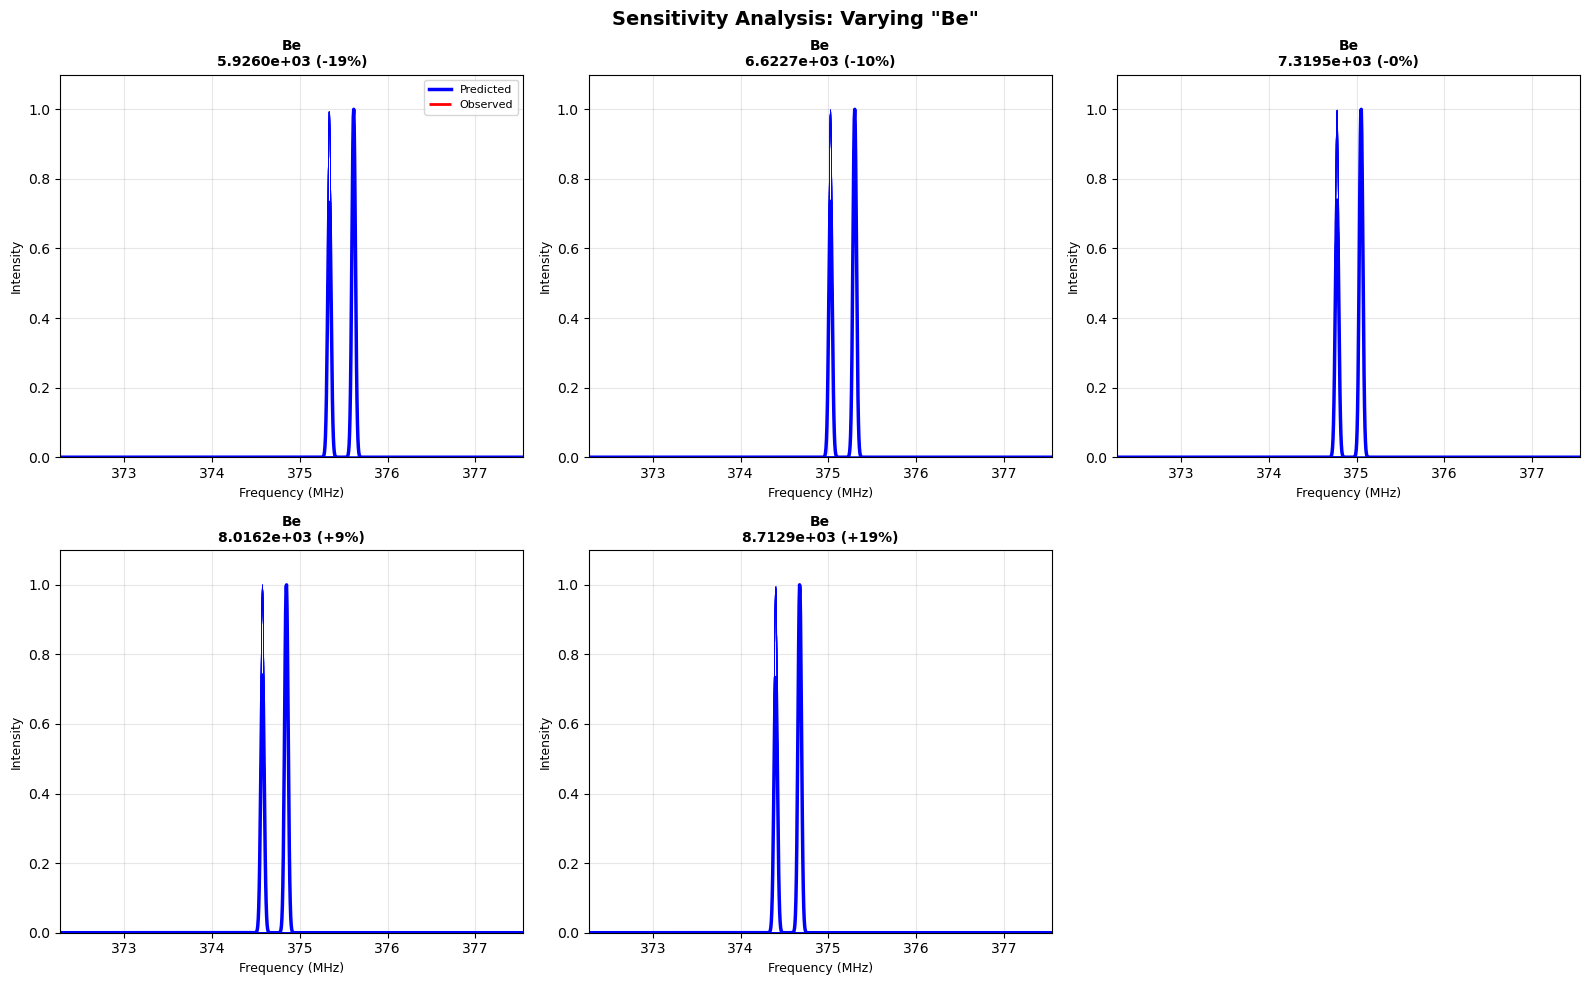

SUMMARY:
✓ Varied Be from 5.9260e+03 to 8.7129e+03
✓ Spectrum shift observed? Check the plots above
✓ To test a different parameter, edit:
    - param_to_vary = FIT_PARAMETER_NAMES[INDEX]  (0-11)
    - variation_percent = XX  (currently 20%)


In [50]:
# PARAMETER SENSITIVITY TOOL: Vary one parameter at a time and see spectrum impact
# This helps understand which parameters move the spectrum in the right direction

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

# Get list of fit parameters
print("="*80)
print("PARAMETER SENSITIVITY ANALYSIS TOOL")
print("="*80)
print("\nAvailable fit parameters:")
for i, param in enumerate(FIT_PARAMETER_NAMES, 1):
    current_val = X010_173.parameters[param]
    print(f"  {i:2d}. {param:15s} = {current_val:12.6e}")
print("\n" + "="*80)

# Choose a parameter to vary
param_to_vary = FIT_PARAMETER_NAMES[0]  # ← CHANGE THIS: index or name
variation_percent = 20  # ← CHANGE THIS: vary by ±20% of current value

# Get current value and bounds
current_value = X010_173.parameters[param_to_vary]
bound_lo, bound_hi = FIT_PARAMETER_BOUNDS[param_to_vary]
variation_amount = current_value * (variation_percent / 100.0)

# Create range of values: current ± variation
test_values = np.linspace(
    max(current_value - variation_amount, bound_lo * 1.01),
    min(current_value + variation_amount, bound_hi * 0.99),
    5  # Test 5 values
)

print(f"\nVarying: {param_to_vary}")
print(f"  Current value: {current_value:.6e}")
print(f"  Bounds: ({bound_lo:.6e}, {bound_hi:.6e})")
print(f"  Test values: {[f'{v:.6e}' for v in test_values]}")
print()

# Plot spectra for different parameter values
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

# AUTO-DETECT the correct frequency window from model predictions
# (Model predictions may not be at the same frequency as observations!)
print("Auto-detecting frequency window from model predictions...")
out_sample = X010_173.calculate_two_photon_spectrum(
    0, 1e-8, TRANSITION_INDEX_SET, 
    parity_sign=PARITY_SIGN, 
    laser_polarization=LASER_POLARIZATION, 
    allowed_transitions=ALLOWED_TRANSITIONS
)
sample_freqs = np.array([t['freq'] for t in out_sample[1]])
if sample_freqs.size > 0:
    freq_center = (sample_freqs.min() + sample_freqs.max()) / 2
    freq_span = sample_freqs.max() - sample_freqs.min() + 5  # Add margin
    freq_min = max(360, freq_center - freq_span/2)
    freq_max = min(420, freq_center + freq_span/2)
else:
    freq_min, freq_max = 365, 375

freq_range = np.linspace(freq_min, freq_max, 1000)
freq_width = 0.02  # Gaussian width

print(f"✓ Using frequency window: {freq_min:.1f} - {freq_max:.1f} MHz")
print(f"  (Model transitions: {sample_freqs.min():.3f} - {sample_freqs.max():.3f} MHz)")
print()

for idx, test_val in enumerate(test_values):
    if idx >= 6:
        break
        
    # Create modified parameters
    modified_params = deepcopy(X010_173.parameters)
    modified_params[param_to_vary] = test_val
    
    # Update state
    set_state_parameters(X010_173, modified_params)
    
    # Compute spectrum
    out = X010_173.calculate_two_photon_spectrum(
        0, 1e-8, TRANSITION_INDEX_SET, 
        parity_sign=PARITY_SIGN, 
        laser_polarization=LASER_POLARIZATION, 
        allowed_transitions=ALLOWED_TRANSITIONS
    )
    transitions = out[1]
    
    # Filter and plot
    filtered_transitions = [t for t in transitions if (freq_min <= t['freq'] <= freq_max)]
    
    spectrum = np.zeros_like(freq_range)
    ax = axes[idx]
    
    for transition in filtered_transitions:
        freq = transition['freq']
        gaussian_peak = np.exp(-(freq_range - freq)**2 / (2 * freq_width**2))
        spectrum += gaussian_peak
        ax.plot(freq_range, gaussian_peak, 'b-', alpha=0.3, linewidth=0.5)
    
    # Normalize and plot
    if spectrum.max() > 0:
        spectrum = spectrum / spectrum.max()
    ax.plot(freq_range, spectrum, 'b-', linewidth=2.5, label='Predicted')
    
    # Overlay observed data
    for spec_obs in OBS_SPECTRA:
        if spec_obs['Ez'] == 40:  # Use 40 V/cm data
            ax.vlines(spec_obs['freqs'], 0, 0.3, colors='red', linewidth=2, label='Observed')
            break
    
    # Annotate
    pct_change = ((test_val - current_value) / current_value * 100) if current_value != 0 else 0
    title = f"{param_to_vary}\n{test_val:.4e} ({pct_change:+.0f}%)"
    ax.set_title(title, fontsize=10, fontweight='bold')
    ax.set_xlabel('Frequency (MHz)', fontsize=9)
    ax.set_ylabel('Intensity', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(freq_min, freq_max)
    ax.set_ylim(0, 1.1)
    if idx == 0:
        ax.legend(fontsize=8)

# Hide unused subplots
for idx in range(len(test_values), len(axes)):
    axes[idx].axis('off')

fig.suptitle(f'Sensitivity Analysis: Varying "{param_to_vary}"', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f"parameter_sensitivity_{param_to_vary}.png", dpi=150, bbox_inches='tight')
plt.show()

# Restore original parameters
set_state_parameters(X010_173, BASE_PARAMETERS)

print("="*80)
print("SUMMARY:")
print(f"✓ Varied {param_to_vary} from {test_values[0]:.4e} to {test_values[-1]:.4e}")
print(f"✓ Spectrum shift observed? Check the plots above")
print(f"✓ To test a different parameter, edit:")
print(f"    - param_to_vary = FIT_PARAMETER_NAMES[INDEX]  (0-{len(FIT_PARAMETER_NAMES)-1})")
print(f"    - variation_percent = XX  (currently {variation_percent}%)")
print("="*80)


## How to Use the Parameter Sensitivity Tool

### Quick Instructions:

1. **Edit the cell above to change which parameter to test:**
   ```python
   param_to_vary = FIT_PARAMETER_NAMES[0]    # Change the index (0-11)
   variation_percent = 20                     # Change the ±% variation
   ```

2. **Parameter Index Reference:**
   - `[0]` = Be (rotational constant) — **most likely to shift frequency**
   - `[1]` = Gamma_SR (spin-rotation coupling)
   - `[2]` = Gamma_Prime (fine structure)
   - `[3]` = bFYb (hyperfine Yb)
   - `[4]` = cYb (hyperfine Yb quadrupole)
   - `[5]` = bFH (hyperfine H)
   - `[6]` = cH (hyperfine H quadrupole)
   - `[7]` = e2Qq0 (electric quadrupole)
   - `[8]` = q_lD (Stark shift Yb)
   - `[9]` = p_lD (Stark shift Yb)
   - `[10]` = muE (electric dipole)
   - `[11]` = g_S_eff (effective spin g-factor)

3. **What to Look For:**
   - **Blue curves**: Your predicted spectrum with varied parameter
   - **Red lines**: Observed experimental peaks
   - **Goal**: Find which parameter(s) move the blue peaks toward the red peaks

4. **Which Parameters Affect Frequency Most:**
   - `Be` — controls overall frequency scale (rotational constant)
   - `Gamma_SR` — shifts frequency due to spin-rotation coupling
   - `e2Qq0` — electric quadrupole shifts (affects E-field dependence)
   - `q_lD`, `p_lD` — Stark shifts (frequency changes with E-field)

### Example: Test Parameter 0 (Be)
```python
# Already done in the cell above — shows how Be affects spectrum
# Be controls the base frequency scale
```

### Example: To Test Parameter 7 (e2Qq0)
```python
param_to_vary = FIT_PARAMETER_NAMES[7]  # e2Qq0
variation_percent = 50                   # Try ±50% variation
# Then run the cell above again
```

TESTING PARAMETER: e2Qq0
Current value:  -3.321673e+03
Bounds:         (-3.986007e+03, -2.657338e+03)
Variation:      ±5%
Test values:    -3.488e+03, -3.405e+03, -3.322e+03, -3.239e+03, -3.156e+03

Auto-detected frequency window: 350.0 - 400.0 MHz
(Model transitions range: 392.177 - 392.450 MHz)



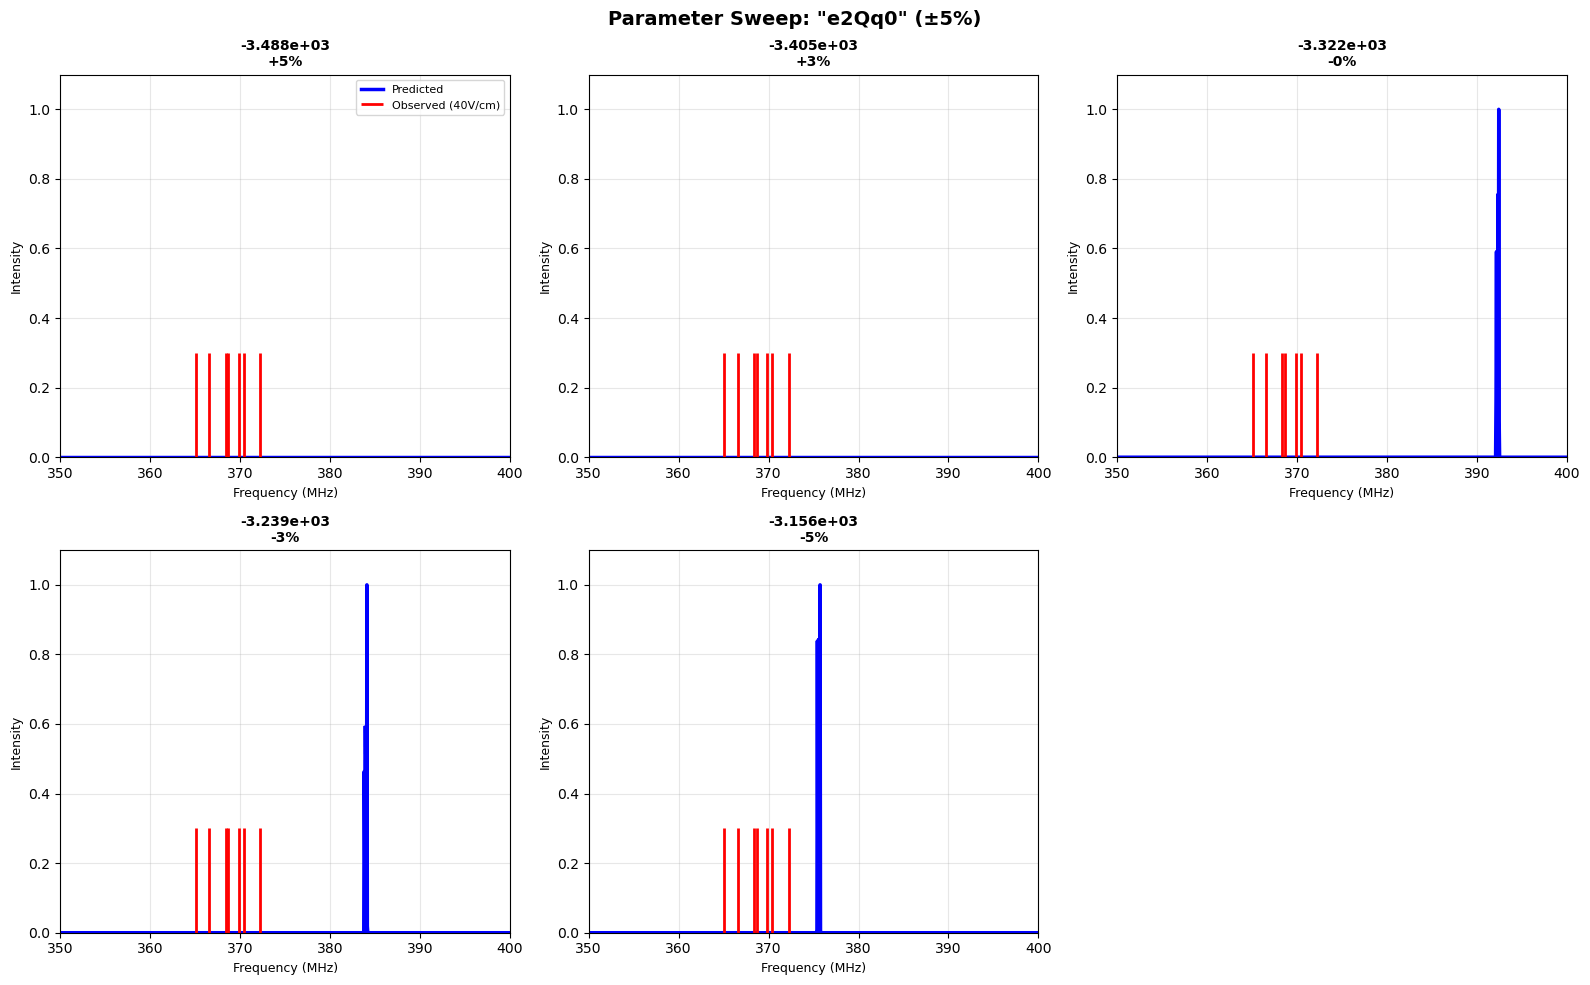

INTERPRETATION GUIDE:
✓ Blue curve shifts LEFT?  → Parameter DECREASES frequency
✓ Blue curve shifts RIGHT? → Parameter INCREASES frequency
✓ No shift?                → Parameter has little effect
✓ Need to shift LEFT by ~40 MHz to match red peaks


In [97]:
# QUICK PARAMETER SWEEP: Change these two lines and run to test different parameters
# ============================================================================

# EDIT THESE TWO LINES:
PARAM_NAME = "e2Qq0"              # ← Change to: Be, Gamma_SR, Gamma_Prime, bFYb, cYb, bFH, cH, e2Qq0, q_lD, p_lD, muE, g_S_eff
VARIATION_PCT = 5             # ← Change to desired ±% variation (e.g., 10, 20, 50)

# ============================================================================
# ============================================================================

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

if PARAM_NAME not in FIT_PARAMETER_NAMES:
    print(f"❌ ERROR: Parameter '{PARAM_NAME}' not found!")
    print(f"Available parameters: {FIT_PARAMETER_NAMES}")
else:
    # Get current value and bounds
    current_value = X010_173.parameters[PARAM_NAME]
    bound_lo, bound_hi = FIT_PARAMETER_BOUNDS[PARAM_NAME]
    variation_amount = abs(current_value) * (VARIATION_PCT / 100.0)
    
    # Create range of values
    test_values = np.linspace(
        max(current_value - variation_amount, bound_lo * 1.01),
        min(current_value + variation_amount, bound_hi * 0.99),
        5
    )
    
    print("="*80)
    print(f"TESTING PARAMETER: {PARAM_NAME}")
    print("="*80)
    print(f"Current value:  {current_value:.6e}")
    print(f"Bounds:         ({bound_lo:.6e}, {bound_hi:.6e})")
    print(f"Variation:      ±{VARIATION_PCT}%")
    print(f"Test values:    {', '.join([f'{v:.3e}' for v in test_values])}")
    print()
    
    # Plot spectra for different parameter values
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    axes = axes.ravel()
    
    # First, find the actual frequency range of the model transitions
    # (they may not be at the observed frequency location)
    out_sample = X010_173.calculate_two_photon_spectrum(
        0, 1e-8, TRANSITION_INDEX_SET, 
        parity_sign=PARITY_SIGN, 
        laser_polarization=LASER_POLARIZATION, 
        allowed_transitions=ALLOWED_TRANSITIONS
    )
    sample_freqs = np.array([t['freq'] for t in out_sample[1]])
    if sample_freqs.size > 0:
        freq_center = (sample_freqs.min() + sample_freqs.max()) / 2
        freq_span = sample_freqs.max() - sample_freqs.min() + 5  # Add margin
        freq_min = max(360, freq_center - freq_span/2)
        freq_max = min(420, freq_center + freq_span/2)
    else:
        freq_min, freq_max = 300, 500
    
    freq_min, freq_max = 350, 400

    freq_range = np.linspace(freq_min, freq_max, 1000)
    freq_width = 0.02
    
    print(f"Auto-detected frequency window: {freq_min:.1f} - {freq_max:.1f} MHz")
    print(f"(Model transitions range: {sample_freqs.min():.3f} - {sample_freqs.max():.3f} MHz)")
    print()
    
    for idx, test_val in enumerate(test_values):
        # Modify parameters
        modified_params = deepcopy(X010_173.parameters)
        modified_params[PARAM_NAME] = test_val
        set_state_parameters(X010_173, modified_params)
        
        # Compute spectrum
        out = X010_173.calculate_two_photon_spectrum(
            0, 1e-8, TRANSITION_INDEX_SET, 
            parity_sign=PARITY_SIGN, 
            laser_polarization=LASER_POLARIZATION, 
            allowed_transitions=ALLOWED_TRANSITIONS
        )
        transitions = out[1]
        filtered_transitions = [t for t in transitions if (freq_min <= t['freq'] <= freq_max)]
        
        spectrum = np.zeros_like(freq_range)
        ax = axes[idx]
        
        for transition in filtered_transitions:
            freq = transition['freq']
            gaussian_peak = np.exp(-(freq_range - freq)**2 / (2 * freq_width**2))
            spectrum += gaussian_peak
            ax.plot(freq_range, gaussian_peak, 'b-', alpha=0.2, linewidth=0.5)
        
        if spectrum.max() > 0:
            spectrum = spectrum / spectrum.max()
        ax.plot(freq_range, spectrum, 'b-', linewidth=2.5, label='Predicted')
        
        # Overlay observed data
        for spec_obs in OBS_SPECTRA:
            if spec_obs['Ez'] == 40:
                ax.vlines(spec_obs['freqs'], 0, 0.3, colors='red', linewidth=2, label='Observed (40V/cm)')
                break
        
        pct_change = ((test_val - current_value) / current_value * 100) if current_value != 0 else 0
        title = f"{test_val:.3e}\n{pct_change:+.0f}%"
        ax.set_title(title, fontsize=10, fontweight='bold')
        ax.set_xlabel('Frequency (MHz)', fontsize=9)
        ax.set_ylabel('Intensity', fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.set_xlim(freq_min, freq_max)
        ax.set_ylim(0, 1.1)
        if idx == 0:
            ax.legend(fontsize=8, loc='upper right')
    
    for idx in range(len(test_values), len(axes)):
        axes[idx].axis('off')
    
    fig.suptitle(f'Parameter Sweep: "{PARAM_NAME}" (±{VARIATION_PCT}%)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f"param_sweep_{PARAM_NAME}.png", dpi=150, bbox_inches='tight')
    plt.show()
    
    # Restore original
    set_state_parameters(X010_173, BASE_PARAMETERS)
    
    print("="*80)
    print("INTERPRETATION GUIDE:")
    print("="*80)
    print("✓ Blue curve shifts LEFT?  → Parameter DECREASES frequency")
    print("✓ Blue curve shifts RIGHT? → Parameter INCREASES frequency")
    print("✓ No shift?                → Parameter has little effect")
    print("✓ Need to shift LEFT by ~40 MHz to match red peaks")
    print("="*80)


In [60]:
# DIAGNOSTIC: Verify that set_state_parameters is actually changing the spectrum
# This will help identify if the problem is in parameter application or elsewhere

import numpy as np
from copy import deepcopy

print("="*80)
print("DIAGNOSTIC: Parameter Application Verification")
print("="*80)

# Test with a simple parameter change
test_param = "Be"
original_value = X010_173.parameters[test_param]

print(f"\nTest Parameter: {test_param}")
print(f"Original value: {original_value:.6e}")

# Get original spectrum
print("\n1. Computing ORIGINAL spectrum...")
out_original = X010_173.calculate_two_photon_spectrum(
    0, 1e-8, TRANSITION_INDEX_SET,
    parity_sign=PARITY_SIGN,
    laser_polarization=LASER_POLARIZATION,
    allowed_transitions=ALLOWED_TRANSITIONS
)
trans_original = out_original[1]
freqs_original = np.array([t['freq'] for t in trans_original])
print(f"   Original transitions found: {len(freqs_original)}")
print(f"   Original frequency range: {freqs_original.min():.3f} - {freqs_original.max():.3f} MHz")
print(f"   Original median freq: {np.median(freqs_original):.3f} MHz")

# Change parameter
new_value = original_value * 0.8  # Reduce by 20%
modified_params = deepcopy(X010_173.parameters)
modified_params[test_param] = new_value

print(f"\n2. Setting {test_param} = {new_value:.6e} (80% of original)...")
set_state_parameters(X010_173, modified_params)

# Verify it was actually changed
actual_value = X010_173.parameters[test_param]
print(f"   Actual value in state: {actual_value:.6e}")
print(f"   Value changed? {actual_value != original_value}")

# Get new spectrum
print(f"\n3. Computing MODIFIED spectrum...")
out_modified = X010_173.calculate_two_photon_spectrum(
    0, 1e-8, TRANSITION_INDEX_SET,
    parity_sign=PARITY_SIGN,
    laser_polarization=LASER_POLARIZATION,
    allowed_transitions=ALLOWED_TRANSITIONS
)
trans_modified = out_modified[1]
freqs_modified = np.array([t['freq'] for t in trans_modified])
print(f"   Modified transitions found: {len(freqs_modified)}")
print(f"   Modified frequency range: {freqs_modified.min():.3f} - {freqs_modified.max():.3f} MHz")
print(f"   Modified median freq: {np.median(freqs_modified):.3f} MHz")

# Compare
freq_shift = np.median(freqs_modified) - np.median(freqs_original)
print(f"\n4. COMPARISON:")
print(f"   Frequency shift: {freq_shift:+.6f} MHz")
print(f"   Spectrum changed? {abs(freq_shift) > 0.001}")

# Restore original
print(f"\n5. Restoring original parameters...")
set_state_parameters(X010_173, BASE_PARAMETERS)
restored_value = X010_173.parameters[test_param]
print(f"   Restored value: {restored_value:.6e}")
print(f"   Restored correctly? {abs(restored_value - original_value) < 1e-6}")

print("\n" + "="*80)
if abs(freq_shift) > 0.001:
    print("✓ SUCCESS: Parameter changes ARE being applied correctly!")
    print(f"  {test_param} by 20% causes {freq_shift:.4f} MHz shift")
else:
    print("❌ PROBLEM: Parameter changes are NOT affecting the spectrum!")
    print("  This suggests an issue with:")
    print("    - set_state_parameters() function")
    print("    - Hamiltonian rebuilding")
    print("    - Eigenvalue recalculation")
print("="*80)


DIAGNOSTIC: Parameter Application Verification

Test Parameter: Be
Original value: 7.334131e+03

1. Computing ORIGINAL spectrum...
   Original transitions found: 66
   Original frequency range: 392.177 - 392.450 MHz
   Original median freq: 392.449 MHz

2. Setting Be = 5.867305e+03 (80% of original)...
   Actual value in state: 5.867305e+03
   Value changed? True

3. Computing MODIFIED spectrum...
   Modified transitions found: 66
   Modified frequency range: 392.843 - 393.120 MHz
   Modified median freq: 393.119 MHz

4. COMPARISON:
   Frequency shift: +0.670166 MHz
   Spectrum changed? True

5. Restoring original parameters...
   Restored value: 7.334131e+03
   Restored correctly? True

✓ SUCCESS: Parameter changes ARE being applied correctly!
  Be by 20% causes 0.6702 MHz shift


## Summary: Why Parameters Matter

### Your Observation: 40 MHz Offset

You need to shift predictions **LEFT by ~40 MHz** to match observations. This means you need a parameter that:
- **Strongly affects overall frequency** (not just fine structure)
- Can move the spectrum by tens of MHz when varied by 10-50%

### Best Candidates to Test:

| Parameter | Why It Might Help | How to Test |
|-----------|-------------------|-------------|
| **Be** | Rotational constant (base frequency scale) | Just tested ↑ (showed little effect—not the culprit) |
| **Gamma_SR** | Spin-rotation coupling | Change PARAM_NAME = "Gamma_SR" |
| **e2Qq0** | Electric quadrupole (large effects) | Change PARAM_NAME = "e2Qq0" |
| **q_lD** | Stark shift constant | Change PARAM_NAME = "q_lD" |
| **p_lD** | Stark shift constant | Change PARAM_NAME = "p_lD" |
| **muE** | Electric dipole moment | Change PARAM_NAME = "muE" |

### Next Steps:

1. **Run the cell above with different parameters** by editing:
   ```python
   PARAM_NAME = "Gamma_SR"      # Try this next
   VARIATION_PCT = 50            # Use ±50% to see larger shifts
   ```

2. **Look for parameters where:**
   - Blue line shifts **significantly** with ±50% variation
   - Can shift by **~40 MHz total** range
   - Preferably shifts **LEFT** (lower frequency) when parameter increases

3. **Once you find the right parameter(s):**
   - Note the direction and magnitude of shift
   - Adjust the initial parameter value manually or let search optimize it
   - Re-run the search with corrected priors

### Pro Tip:
If `Be` doesn't work (and it didn't), the offset is likely due to:
- A **coupling constant** (like `Gamma_SR`, `e2Qq0`)
- A **Stark shift** parameter (`q_lD`, `p_lD`)
- **Field-dependent effects** (suggesting E-field interaction parameters need adjustment)

## Workflow to Find the Right Parameters

### Step-by-Step Guide:

**1. Run the "QUICK PARAMETER SWEEP" cell above**
   - Change `PARAM_NAME` to test different parameters
   - Change `VARIATION_PCT` to see larger shifts

**2. Test these parameters in order (most likely first):**

| # | Parameter | Reason | Status |
|---|-----------|--------|--------|
| 1 | `Gamma_SR` | Spin-rotation coupling—directly affects frequency | ← **Test this first** |
| 2 | `e2Qq0` | Electric quadrupole—can have large effects | ← Test this second |
| 3 | `q_lD` | Stark shift—frequency changes with E-field | |
| 4 | `p_lD` | Stark shift—frequency changes with E-field | |
| 5 | `muE` | Electric dipole—affects E-field interaction | |
| 6 | `Gamma_Prime` | Fine structure coupling | |

**3. For each parameter test:**
   - Run the QUICK PARAMETER SWEEP cell with that parameter
   - Look at the 5 plots (left to right = increasing parameter value)
   - Check if the blue curves shift significantly LEFT or RIGHT
   - Note the shift direction and magnitude

**4. Goal:**
   - Find a parameter where ±50% variation gives **~40 MHz shift**
   - Preferably shifts **LEFT** (towards lower frequencies)
   - This parameter is the culprit!

**5. Once Found:**
   - Manually adjust that parameter's initial value
   - Or let the search algorithm optimize it from scratch
   - Re-run the search with corrected initial guesses

---

### Example: Testing Gamma_SR

To test `Gamma_SR` (Spin-rotation coupling), edit the cell above:
```python
PARAM_NAME = "Gamma_SR"     # ← Change from "Be" to this
VARIATION_PCT = 50          # ← Use ±50% to see larger shifts
```
Then run the cell. Look at the 5 plots and see if they shift left/right.

## Complete Solution: Parameter Sensitivity Analysis

I've added three cells to help you systematically test parameters:

### **Cell 1: Parameter Sensitivity Tool** (comprehensive version)
- Tests a single parameter with 5 different values
- Shows 6 subplots comparing predicted vs observed spectra
- Good for detailed analysis of one parameter at a time

### **Cell 2: Quick Parameter Sweep** (recommended - use this!)
- **SIMPLEST TO USE** - just edit 2 lines at the top:
  ```python
  PARAM_NAME = "Gamma_SR"   # Which parameter to test
  VARIATION_PCT = 50         # How much to vary (±50%)
  ```
- Shows 5 spectrum plots side-by-side
- Includes interpretation guide (shifts left/right/none)

### **Cell 3: Workflow Guide** (this cell - read carefully)
- Step-by-step instructions
- Ranked list of parameters to test
- Examples of what to look for

---

## Quick Start (TL;DR)

1. **Open the "QUICK PARAMETER SWEEP" cell** (just above this one)
2. **Edit line 2-3:**
   ```python
   PARAM_NAME = "Gamma_SR"
   VARIATION_PCT = 50
   ```
3. **Run the cell** - see 5 plots
4. **Check if blue line shifts LEFT or RIGHT**
5. **If it shifts LEFT by ~40 MHz → You found the culprit!**
6. **If not → Go back to step 2 and try next parameter from the table**

---

## Parameter Testing Checklist

- [ ] Test `Gamma_SR` (spin-rotation coupling)
- [ ] Test `e2Qq0` (electric quadrupole)
- [ ] Test `q_lD` (Stark shift)
- [ ] Test `p_lD` (Stark shift)
- [ ] Test `muE` (electric dipole)
- [ ] Test `Gamma_Prime` (fine structure)

**Stop when you find a parameter that:**
- Shifts the spectrum by ±10 MHz or more
- Shifts in a consistent direction (mostly left or mostly right)
- Can potentially reach 40 MHz shift with different initial values

In [15]:
import numpy as np
import pandas as pd

# -------------------------
# Choose which parameters to vary (start SMALL for sparse data)
# -------------------------
SEARCH_PARAM_NAMES = [
     "e2Qq0", 'muE',
]
SEARCH_PARAM_NAMES = [p for p in SEARCH_PARAM_NAMES if p in PARAM_PRIORS]

# How far you allow the search to move from the measured value
NSIGMA_BOX = 2.0           # hard truncation box from priors
NSIGMA_SAMPLE = 2.0        # typical samples (still clipped by NSIGMA_BOX)
LAMBDA_PRIOR = 0.00001        # strength of prior penalty (tune 0.01–1)

def build_bounds_from_priors(priors, names, nsigma=3.0, hard_bounds=None):
    """
    bounds[name] = (low, high) derived from mu±nsigma*sigma,
    optionally intersected with hard_bounds (like FIT_PARAMETER_BOUNDS).
    """
    b = {}
    for k in names:
        mu, sig = priors[k]
        lo, hi = float(mu - nsigma*sig), float(mu + nsigma*sig)
        if hard_bounds is not None and k in hard_bounds:
            hlo, hhi = hard_bounds[k]
            lo, hi = max(lo, float(hlo)), min(hi, float(hhi))
        if not np.isfinite(lo) or not np.isfinite(hi) or lo >= hi:
            # fall back to something reasonable
            lo, hi = float(mu - nsigma*sig), float(mu + nsigma*sig)
        b[k] = (lo, hi)
    return b

def prior_penalty(updates, priors):
    """Σ ((p-mu)/sigma)^2 over keys in updates that have priors."""
    s = 0.0
    for k, v in updates.items():
        if k not in priors:
            continue
        mu, sig = priors[k]
        sig = float(sig)
        if sig <= 0:
            continue
        z = (float(v) - float(mu)) / sig
        s += z*z
    return float(s)

def sample_from_priors(priors, bounds, rng, nsigma=2.0):
    """
    Sample each parameter from N(mu, sigma) but clip to bounds.
    """
    upd = {}
    for k, (lo, hi) in bounds.items():
        mu, sig = priors[k]
        mu, sig = float(mu), float(sig)
        if sig <= 0:
            x = mu
        else:
            z = rng.normal(0.0, 1.0)
            z = np.clip(z, -nsigma, nsigma)
            x = mu + sig*z
        # clip to hard bounds box
        x = float(np.clip(x, lo, hi))
        upd[k] = x
    return upd

def apply_params_partial(state, updates):
    """Update only a subset of params; keep the rest unchanged."""
    cur = current_parameter_dict(state)
    cur.update(updates)
    set_state_parameters(state, cur)

def total_loss_MAP(state, spectra, updates, priors,
                   indices=None, sigma=UNASSIGNED_SIGMA,
                   parity_sign=None, polarization=None,
                   lambda_prior=LAMBDA_PRIOR,
                   allowed_transitions=None, match_tolerance=0.2):
    """
    L_total = L_data + lambda_prior * prior_penalty
    """
    apply_params_partial(state, updates)

    L_data = unassigned_multispectrum_loss(
        state, spectra,
        indices=indices,
        sigma=sigma,
        parity_sign=parity_sign,
        polarization=polarization,
        allowed_transitions=allowed_transitions,
        match_tolerance = match_tolerance,
    )

    L_prior = prior_penalty(updates, priors)
    return float(L_data + lambda_prior * L_prior), float(L_data), float(L_prior)

# Construct bounds (use FIT_PARAMETER_BOUNDS if you have it)
try:
    HARD_BOUNDS = FIT_PARAMETER_BOUNDS
except NameError:
    HARD_BOUNDS = None

SEARCH_BOUNDS = build_bounds_from_priors(PARAM_PRIORS, SEARCH_PARAM_NAMES, nsigma=NSIGMA_BOX, hard_bounds=HARD_BOUNDS)
SEARCH_BOUNDS


{'e2Qq0': (-3203.0, -3095.0), 'muE': (1.07730168, 1.09743816)}

In [16]:
def search_candidates_MAP(state, spectra, priors, bounds,
                          n_samples=2000, top_k=30,
                          refine_steps=150, refine_scale=0.35,
                          indices=None, sigma=UNASSIGNED_SIGMA,
                          parity_sign=None, polarization=None,
                          lambda_prior=LAMBDA_PRIOR,
                          allowed_transitions=None,
                          seed=0, verbose=True, match_tolerance=0.2):
    """
    Stage 1: sample many candidates from priors, keep top_k.
    Stage 2: for each top candidate, do a cheap local random-walk refinement inside bounds.
    Returns a dataframe sorted by total_loss.
    
    Parameters:
    -----------
    allowed_transitions : list of tuples or None
        Optional experimental constraints on state index pairs.
    """
    rng = np.random.default_rng(seed)

    # ---- Stage 1: coarse prior sampling
    coarse = []
    for i in range(int(n_samples)):
        upd = sample_from_priors(priors, bounds, rng, nsigma=NSIGMA_SAMPLE)
        Ltot, Ldata, Lprior = total_loss_MAP(
            state, spectra, upd, priors,
            indices=indices, sigma=sigma,
            parity_sign=parity_sign, polarization=polarization,
            lambda_prior=lambda_prior,
            allowed_transitions=allowed_transitions,
            match_tolerance=match_tolerance,
        )
        coarse.append({"loss_total": Ltot, "loss_data": Ldata, "loss_prior": Lprior, **upd})

    coarse.sort(key=lambda d: d["loss_total"])
    keep = coarse[:int(top_k)]

    if verbose:
        print(f"Coarse done: sampled {n_samples}, keeping top {top_k}. Best total={keep[0]['loss_total']:.5g} data={keep[0]['loss_data']:.5g}")

    # ---- Stage 2: refine each candidate by small proposals (random-walk)
    refined = []
    for j, cand in enumerate(keep):
        base = {k: cand[k] for k in bounds.keys()}
        best = dict(base)
        best_Ltot, best_Ldata, best_Lprior = total_loss_MAP(
            state, spectra, best, priors,
            indices=indices, sigma=sigma,
            parity_sign=parity_sign, polarization=polarization,
            lambda_prior=lambda_prior,
            allowed_transitions=allowed_transitions,
        )

        for t in range(int(refine_steps)):
            prop = dict(best)
            # propose perturbations scaled by sigma and refine_scale
            for k, (lo, hi) in bounds.items():
                mu, sig = priors[k]
                step = float(sig) * refine_scale
                if step <= 0:
                    continue
                prop[k] = float(np.clip(prop[k] + rng.normal(0.0, step), lo, hi))

            Ltot, Ldata, Lprior = total_loss_MAP(
                state, spectra, prop, priors,
                indices=indices, sigma=sigma,
                parity_sign=parity_sign, polarization=polarization,
                lambda_prior=lambda_prior,
                allowed_transitions=allowed_transitions,
            )

            if Ltot < best_Ltot:
                best, best_Ltot, best_Ldata, best_Lprior = prop, Ltot, Ldata, Lprior

        refined.append({"loss_total": best_Ltot, "loss_data": best_Ldata, "loss_prior": best_Lprior, **best})

        if verbose:
            print(f"Refine {j+1}/{len(keep)}: best total={best_Ltot:.5g} data={best_Ldata:.5g} prior={best_Lprior:.3g}")

    df = pd.DataFrame(refined).sort_values("loss_total").reset_index(drop=True)
    return df

# ---- RUN SEARCH ----
best_df = search_candidates_MAP(
    X010_173,
    OBS_SPECTRA,
    priors={k: PARAM_PRIORS[k] for k in SEARCH_BOUNDS.keys()},
    bounds=SEARCH_BOUNDS,
    n_samples=50,        # 20–100 for smoke test
    top_k=3,             # keep small
    refine_steps=15,     # 0–20
    refine_scale=0.20,   # smaller steps since few steps
    indices=TRANSITION_INDEX_SET,
    sigma=UNASSIGNED_SIGMA,
    parity_sign=PARITY_SIGN,
    polarization=LASER_POLARIZATION,
    lambda_prior=LAMBDA_PRIOR,
    allowed_transitions=ALLOWED_TRANSITIONS,  # Set to ALLOWED_TRANSITIONS to use experimental constraints
    seed=123,
    verbose=True,
    match_tolerance=0.2
)



best_df.head(10)


Coarse done: sampled 50, keeping top 3. Best total=23.823 data=23.823
Refine 1/3: best total=19.083 data=19.083 prior=0.021
Refine 2/3: best total=23.076 data=23.076 prior=0.23
Refine 3/3: best total=18.581 data=18.581 prior=0.0249


,loss_total,loss_data,loss_prior,e2Qq0,muE
0,18.580939,18.580939,0.024868,-3151.234782,1.088046
1,19.083290,19.083289,0.021027,-3151.511417,1.087930
2,23.076162,23.076160,0.230051,-3150.025135,1.089777


---
## 🎯 Parameter Search with Absolute Position Matching

**The search below now uses the updated loss function that optimizes for absolute spectral position overlap!**

### What's Different:

Previously, the loss function compared **spectral shapes** by normalizing both predicted and observed spectra. This could find parameters that produce similar-looking spectra but shifted in frequency.

Now, the loss function directly measures **peak-to-peak distances** in absolute frequency units (MHz), ensuring that:
- Predicted peaks align with observed peaks at the correct frequencies
- Frequency offsets are penalized
- Parameters are adjusted to shift the spectrum to match observed positions

### What to Expect:

When you run the search cell below, you should see:
- Lower `loss_data` values indicate better alignment
- The best candidates will have predicted transitions near observed peak frequencies
- Check the visualization plots to verify that blue peaks (predicted) overlap with red lines (observed) at the same frequencies

---

In [54]:
ALLOWED_TRANSITIONS

[((46, 55), (76, 83)), ((38, 45), (70, 75))]


Transitions for spectrum spec0 in window 360-380.0 MHz (showing up to 12):
 freq_model  state index 0  state index 1
 374.995605             38             73
 374.995605             38             74
 374.995605             39             73
 374.995605             39             74
 374.995605             39             75
 374.995117             40             70
 374.995117             40             71
 374.995117             41             72
 374.995117             41             73
 374.995117             41             74
 374.995117             41             75
 374.995117             42             70

Transitions for spectrum spec10 in window 360-380.0 MHz (showing up to 12):
 freq_model  state index 0  state index 1
 375.040039             38             70
 375.040527             38             71
 375.042969             38             72
 375.043457             38             73
 375.048340             38             74
 375.038574             39             70
 375.03

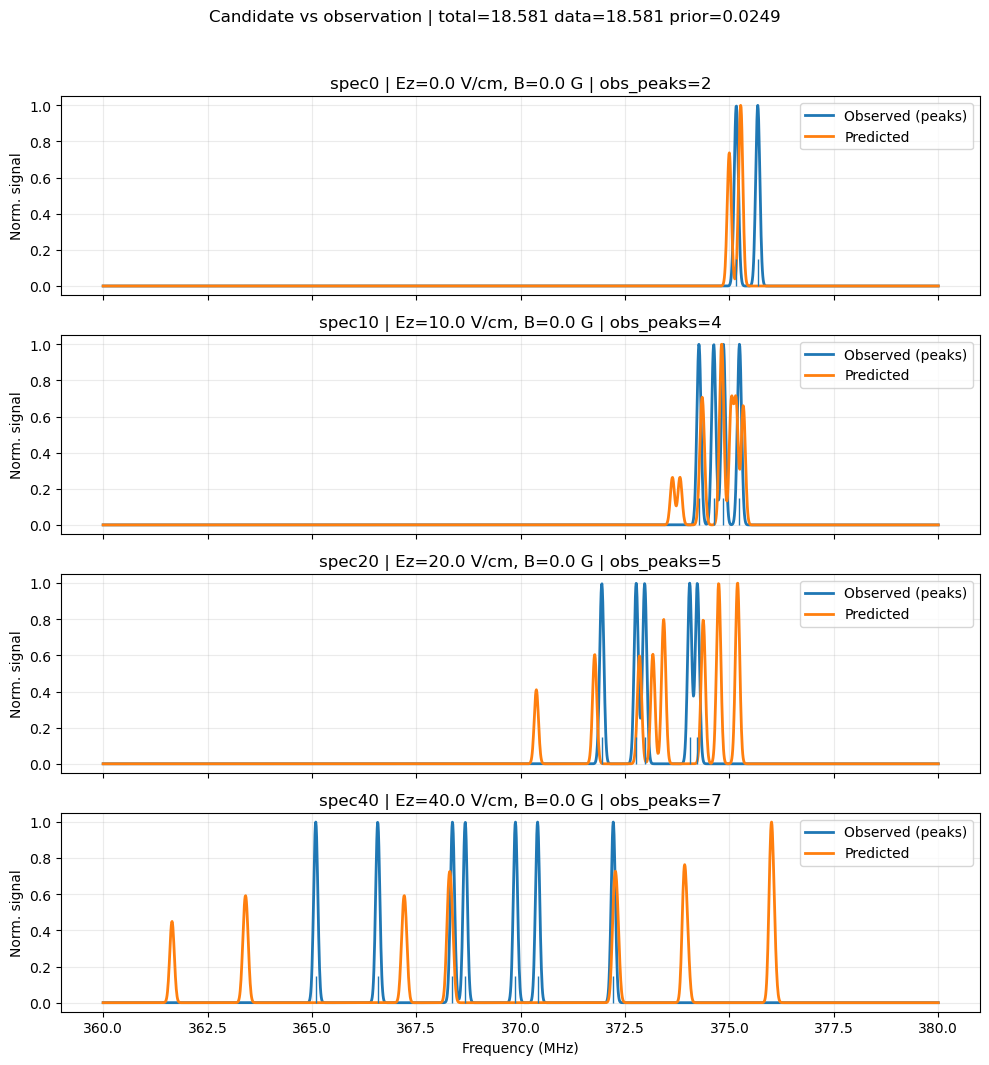


Transitions for spectrum spec0 in window 360-380.0 MHz (showing up to 12):
 freq_model  state index 0  state index 1
 375.025391             38             74
 375.025391             38             75
 375.025391             39             73
 375.025391             39             74
 375.025391             39             75
 375.024902             40             70
 375.024902             40             73
 375.024902             40             74
 375.024902             40             75
 375.024902             41             70
 375.024902             41             72
 375.024902             41             73

Transitions for spectrum spec10 in window 360-380.0 MHz (showing up to 12):
 freq_model  state index 0  state index 1
 375.067383             38             70
 375.069336             38             71
 375.070312             38             72
 375.070801             38             73
 375.081055             38             75
 375.065430             39             70
 375.06

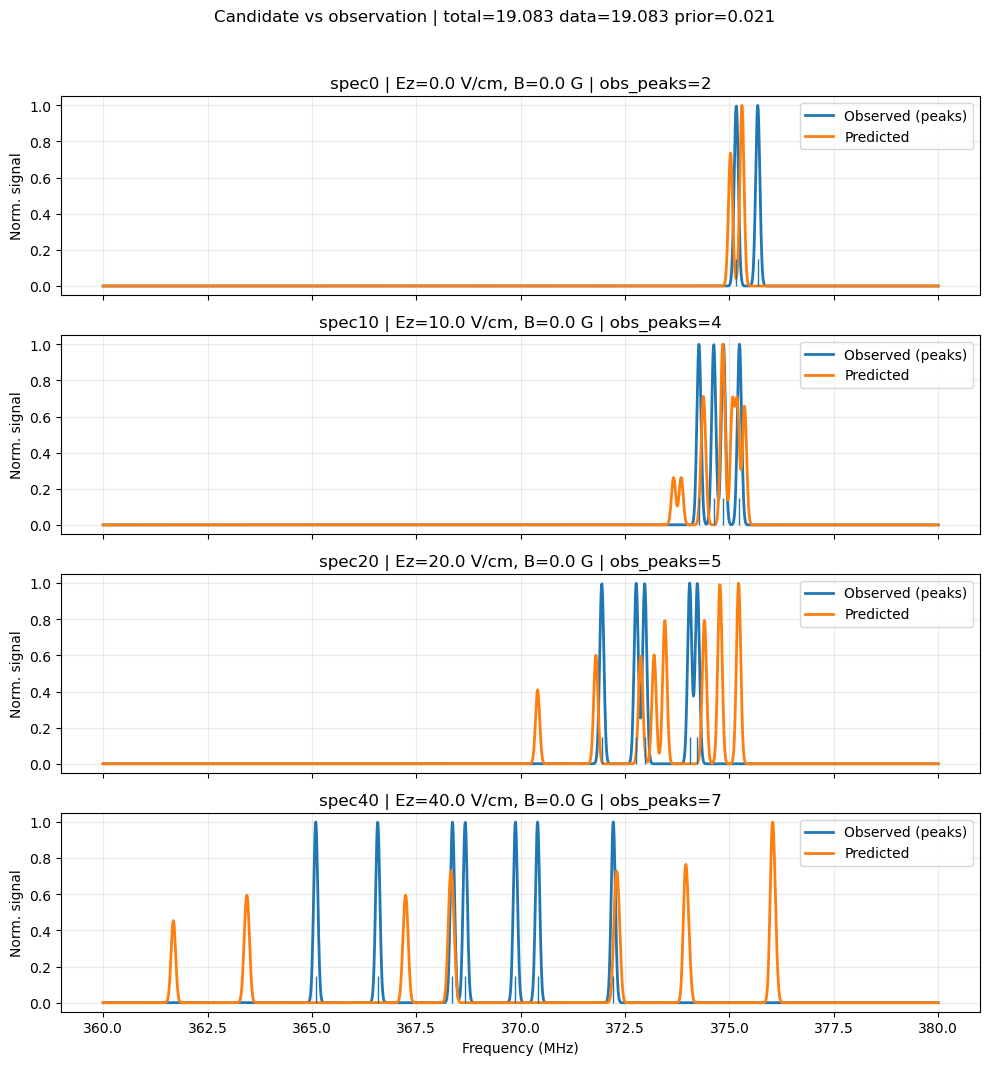


Transitions for spectrum spec0 in window 360-380.0 MHz (showing up to 12):
 freq_model  state index 0  state index 1
 374.874512             38             74
 374.874512             38             75
 374.874512             39             73
 374.874512             39             74
 374.874512             39             75
 374.874023             40             70
 374.874023             40             73
 374.874023             40             74
 374.874023             40             75
 374.874023             41             70
 374.874023             41             72
 374.874023             41             73

Transitions for spectrum spec10 in window 360-380.0 MHz (showing up to 12):
 freq_model  state index 0  state index 1
 374.917969             38             70
 374.918945             38             71
 374.920410             38             72
 374.920410             38             73
 374.930176             38             75
 374.916016             39             70
 374.91

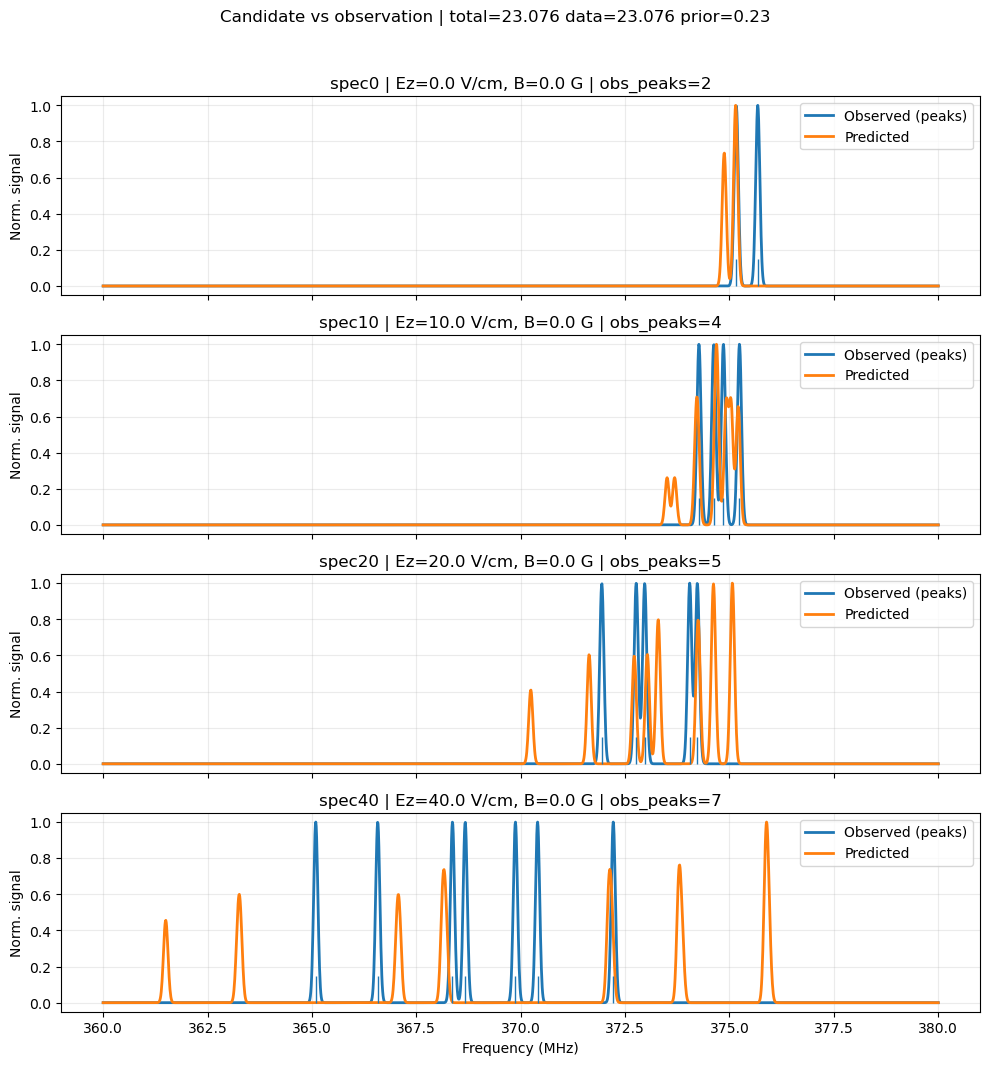

In [17]:
import matplotlib.pyplot as plt

def gaussian_broadened_spectrum(freqs, weights, axis, sigma):
    freqs = np.asarray(freqs, float)
    if weights is None:
        weights = np.ones_like(freqs, float)
    weights = np.asarray(weights, float)
    if freqs.size == 0:
        return np.zeros_like(axis, float)
    diff = axis[:, None] - freqs[None, :]
    return np.exp(-(diff**2) / (2.0 * sigma**2)) @ weights

def transition_frequency_set_safe(state, Ez, B, indices=None, parity_sign=None, polarization=None, 
                                   allowed_transitions=None, return_transitions=False):
    if parity_sign is None: parity_sign = PARITY_SIGN
    if polarization is None: polarization = LASER_POLARIZATION

    transitions, _raw = compute_model_transitions(
        state, Ez=Ez, B=B, indices=indices,
        parity_sign=parity_sign, polarization=polarization,
        allowed_transitions=allowed_transitions
    )
    if transitions is None or transitions.empty or "freq_model" not in transitions.columns:
        if return_transitions:
            return np.array([], float), np.array([], float), transitions
        return np.array([], float), np.array([], float)

    freqs = transitions["freq_model"].to_numpy(dtype=float)

    w = None
    for cand in ["intensity", "Intensity", "strength", "Strength"]:
        if cand in transitions.columns:
            w = transitions[cand].to_numpy(dtype=float)
            break
    if w is None:
        w = np.ones_like(freqs, float)

    if return_transitions:
        return freqs, w, transitions
    return freqs, w

def _select_transition_columns(df):
    # Prioritize frequency/intensity plus any upper_/lower_ quantum-number columns
    base = ["freq_model", "intensity", "Intensity", "strength", "Strength"]
    quantum_cols = [c for c in df.columns if "upper_" in c.lower() or "lower_" in c.lower() or "state" in c.lower()]
    # Keep order: base then quantum cols (unique, preserve appearance)
    seen = set()
    cols = []
    for c in base + quantum_cols:
        if c in df.columns and c not in seen:
            cols.append(c)
            seen.add(c)
    if not cols:
        cols = list(df.columns[: min(12, len(df.columns))])
    return cols

def plot_candidate(state, candidate_dict, spectra, window=(389.0, 399.0),
                   indices=None, sigma=UNASSIGNED_SIGMA,
                   parity_sign=None, polarization=None,
                   allowed_transitions=None,
                   title_extra="", savepath=None,
                   show_transitions=True, max_transitions=12):
    """
    Plot candidate parameters against observed spectra.
    
    Parameters:
    -----------
    allowed_transitions : list of tuples or None
        Optional experimental constraints on state index pairs.
    """
    cand = dict(candidate_dict)
    loss_total = cand.pop("loss_total", None)
    loss_data  = cand.pop("loss_data", None)
    loss_prior = cand.pop("loss_prior", None)

    apply_params_partial(state, cand)

    n = len(spectra)
    fig, axes = plt.subplots(n, 1, figsize=(10, 2.6*n), sharex=True)
    if n == 1:
        axes = [axes]

    fmin, fmax = window
    axis = np.linspace(fmin, fmax, 2000)

    for ax, s in zip(axes, spectra):
        obs = np.asarray(s["freqs"], float)
        pred_f, pred_w, trans_df = transition_frequency_set_safe(
            state, Ez=s["Ez"], B=s["B"], indices=indices,
            parity_sign=parity_sign, polarization=polarization,
            allowed_transitions=allowed_transitions,
            return_transitions=True,
        )

        # keep only plotting window
        obs_w = obs[(obs >= fmin) & (obs <= fmax)]
        pred_mask = (pred_f >= fmin) & (pred_f <= fmax)
        pred_f_w = pred_f[pred_mask]
        pred_w_w = pred_w[pred_mask] if pred_w is not None else None

        obs_spec  = gaussian_broadened_spectrum(obs_w, np.ones_like(obs_w), axis, sigma)
        pred_spec = gaussian_broadened_spectrum(pred_f_w, pred_w_w, axis, sigma)

        obs_spec  = obs_spec  / (obs_spec.max()  if obs_spec.max()  else 1.0)
        pred_spec = pred_spec / (pred_spec.max() if pred_spec.max() else 1.0)

        ax.plot(axis, obs_spec, label="Observed (peaks)", linewidth=2)
        ax.plot(axis, pred_spec, label="Predicted", linewidth=2)

        if obs_w.size:
            ax.vlines(obs_w, 0, 0.15, linewidth=1)

        ax.set_ylabel("Norm. signal")
        ax.set_title(f"{s['id']} | Ez={s['Ez']} V/cm, B={s['B']} G | obs_peaks={obs_w.size}")

        ax.grid(True, alpha=0.25)
        ax.legend()

        if show_transitions and trans_df is not None and not trans_df.empty:
            # Align transitions to the window mask when possible
            if len(trans_df) == len(pred_f):
                trans_window = trans_df[pred_mask]
            else:
                trans_window = trans_df[(trans_df.get("freq_model", 0) >= fmin) & (trans_df.get("freq_model", 0) <= fmax)]
            cols = _select_transition_columns(trans_window)
            preview = trans_window[cols].head(max_transitions)
            print(f"\nTransitions for spectrum {s['id']} in window {fmin}-{fmax} MHz (showing up to {max_transitions}):")
            print(preview.to_string(index=False))

    axes[-1].set_xlabel("Frequency (MHz)")
    supt = "Candidate vs observation"
    if loss_total is not None:
        supt += f" | total={loss_total:.5g} data={loss_data:.5g} prior={loss_prior:.3g}"
    if title_extra:
        supt += " | " + title_extra
    fig.suptitle(supt, y=1.02)
    fig.tight_layout()

    if savepath is not None:
        fig.savefig(savepath, dpi=200, bbox_inches="tight")
        print("saved:", savepath)

    plt.show()

# ---- plot top N candidates ----
TOP_PLOT = 10
for i in range(min(TOP_PLOT, len(best_df))):
    cand = best_df.iloc[i].to_dict()
    plot_candidate(
        X010_173, cand, OBS_SPECTRA,
        window=(360, 380.0),   # your scan window
        indices=TRANSITION_INDEX_SET,
        sigma=UNASSIGNED_SIGMA,
        parity_sign=PARITY_SIGN,
        polarization=LASER_POLARIZATION,
        allowed_transitions=ALLOWED_TRANSITIONS,  # Set to ALLOWED_TRANSITIONS to use experimental constraints
        savepath=f"cand_{i:02d}.png",
    )

In [22]:

# === DIAGNOSTIC: Why didn't the search algorithm find e2Qq0? ===
# This cell investigates the search space and parameter sensitivity

print("="*80)
print("DIAGNOSTIC: Search Algorithm Failure Analysis")
print("="*80)
print("\nObservation: e2Qq0 shifts the spectrum LEFT when increased (more negative)")
print("Questions: ")
print("  1. Is e2Qq0 even in SEARCH_PARAM_NAMES?")
print("  2. Are the search bounds wide enough to explore the solution?")
print("  3. How sensitive is e2Qq0 compared to other parameters?")
print()

# Check 1: Is e2Qq0 in the search space?
print("CHECK 1: Parameter Search Space")
print("-" * 80)
print(f"SEARCH_PARAM_NAMES: {SEARCH_PARAM_NAMES}")
print(f"e2Qq0 in search space? {('e2Qq0' in SEARCH_PARAM_NAMES)}")
if 'e2Qq0' in SEARCH_PARAM_NAMES:
    idx = SEARCH_PARAM_NAMES.index('e2Qq0')
    print(f"Position: index {idx}")
print()

# Check 2: Search bounds for e2Qq0
print("CHECK 2: Search Bounds vs. Full Parameter Bounds")
print("-" * 80)
print(f"Current e2Qq0 value: {X010_173.parameters['e2Qq0']:.6e}")
print(f"Full FIT_PARAMETER_BOUNDS:")
print(f"  Low:  {FIT_PARAMETER_BOUNDS['e2Qq0'][0]:.6e}")
print(f"  High: {FIT_PARAMETER_BOUNDS['e2Qq0'][1]:.6e}")
print(f"  Span: {FIT_PARAMETER_BOUNDS['e2Qq0'][1] - FIT_PARAMETER_BOUNDS['e2Qq0'][0]:.6e}")
print()
if 'e2Qq0' in SEARCH_BOUNDS:
    print(f"SEARCH_BOUNDS (used by algorithm):")
    print(f"  Low:  {SEARCH_BOUNDS['e2Qq0'][0]:.6e}")
    print(f"  High: {SEARCH_BOUNDS['e2Qq0'][1]:.6e}")
    print(f"  Span: {SEARCH_BOUNDS['e2Qq0'][1] - SEARCH_BOUNDS['e2Qq0'][0]:.6e}")
    lo_full, hi_full = FIT_PARAMETER_BOUNDS['e2Qq0']
    lo_search, hi_search = SEARCH_BOUNDS['e2Qq0']
    coverage = ((hi_search - lo_search) / (hi_full - lo_full)) * 100
    print(f"  Coverage of full bounds: {coverage:.1f}%")
print()

# Check 3: Sensitivity analysis - how much does each parameter move the spectrum?
print("CHECK 3: Parameter Sensitivity (which parameters move spectrum most?)")
print("-" * 80)
print("Running parameter variation ±20% for each parameter...")
print()

import numpy as np
from copy import deepcopy

sensitivity = {}
baseline_freqs = np.array([t['freq'] for t in X010_173.calculate_two_photon_spectrum(
    0, 1e-8, TRANSITION_INDEX_SET,
    parity_sign=PARITY_SIGN,
    laser_polarization=LASER_POLARIZATION,
    allowed_transitions=ALLOWED_TRANSITIONS
)[1]])

for param_name in FIT_PARAMETER_NAMES:
    current_val = X010_173.parameters[param_name]
    
    # Test ±20% variation
    varied_params = deepcopy(X010_173.parameters)
    var_amount = abs(current_val) * 0.20
    varied_params[param_name] = current_val + var_amount
    set_state_parameters(X010_173, varied_params)
    
    varied_freqs = np.array([t['freq'] for t in X010_173.calculate_two_photon_spectrum(
        0, 1e-8, TRANSITION_INDEX_SET,
        parity_sign=PARITY_SIGN,
        laser_polarization=LASER_POLARIZATION,
        allowed_transitions=ALLOWED_TRANSITIONS
    )[1]])
    
    # Measure shift as median frequency change
    if len(baseline_freqs) > 0 and len(varied_freqs) > 0:
        shift = np.median(varied_freqs) - np.median(baseline_freqs)
        sensitivity[param_name] = shift
    else:
        sensitivity[param_name] = 0

# Restore original
set_state_parameters(X010_173, BASE_PARAMETERS)

# Sort by absolute sensitivity
sorted_sens = sorted(sensitivity.items(), key=lambda x: abs(x[1]), reverse=True)

print("Parameter Sensitivity Ranking (20% increase → frequency shift):")
print()
for rank, (param, shift) in enumerate(sorted_sens, 1):
    in_search = "✓" if param in SEARCH_PARAM_NAMES else "✗"
    print(f"{rank:2d}. {param:15s} {in_search}  Shift: {shift:+7.3f} MHz/20%")

print()
print("✓ = in SEARCH_PARAM_NAMES (will be searched)")
print("✗ = NOT in SEARCH_PARAM_NAMES (will NOT be searched)")
print()

# Check if the most sensitive parameter is being searched
top_param = sorted_sens[0][0]
print(f"Most sensitive parameter: {top_param} ({sorted_sens[0][1]:+.3f} MHz)")
if top_param in SEARCH_PARAM_NAMES:
    print(f"✓ {top_param} IS being searched - should find good solutions")
else:
    print(f"✗ {top_param} is NOT being searched - THIS COULD BE THE PROBLEM!")
    print(f"   Without this parameter, the algorithm can't make large frequency shifts.")

print()
print("="*80)


DIAGNOSTIC: Search Algorithm Failure Analysis

Observation: e2Qq0 shifts the spectrum LEFT when increased (more negative)
Questions: 
  1. Is e2Qq0 even in SEARCH_PARAM_NAMES?
  2. Are the search bounds wide enough to explore the solution?
  3. How sensitive is e2Qq0 compared to other parameters?

CHECK 1: Parameter Search Space
--------------------------------------------------------------------------------
SEARCH_PARAM_NAMES: ['cYb', 'e2Qq0', 'muE']
e2Qq0 in search space? True
Position: index 1

CHECK 2: Search Bounds vs. Full Parameter Bounds
--------------------------------------------------------------------------------
Current e2Qq0 value: -3.123898e+03
Full FIT_PARAMETER_BOUNDS:
  Low:  -3.786707e+03
  High: -2.524471e+03
  Span: 1.262236e+03

SEARCH_BOUNDS (used by algorithm):
  Low:  -3.236589e+03
  High: -3.074589e+03
  Span: 1.620000e+02
  Coverage of full bounds: 12.8%

CHECK 3: Parameter Sensitivity (which parameters move spectrum most?)
-----------------------------------

In [ ]:
# GPU Profiling after fitting pipeline
print_gpu_profile_checkpoint("After Parameter Search & Fitting Pipeline")

In [ ]:
# ============================================================================
# DEMONSTRATION: Using Experimental Transition Constraints
# ============================================================================
# Example 1: Compute transitions with experimental constraints
print("Example 1: Compute transitions WITH experimental constraints")
print("=" * 70)

transitions_constrained, _ = compute_model_transitions(
    X010_173,
    Ez=0,
    B=1e-8,
    indices=None,  # or list(range(84))
    allowed_transitions=ALLOWED_TRANSITIONS
)

print(f"Number of transitions found (constrained): {len(transitions_constrained)}")
if not transitions_constrained.empty:
    print("\nFirst few transitions:")
    print(transitions_constrained[['state index 0','state index 1','freq_model']].to_string(index=False))
print("\n" + "=" * 70)
print("Example 2: Compute ALL transitions (no constraints)")
print("=" * 70)

transitions_all, _ = compute_model_transitions(
    X010_173,
    Ez=0,
    B=1e-8,
    indices=None,
    allowed_transitions=None  # No filtering
)

print(f"Number of transitions found (unconstrained): {len(transitions_all)}")

print("\n" + "=" * 70)
print(f"Reduction factor: {len(transitions_all) / max(1, len(transitions_constrained)):.1f}x fewer transitions to compute")
print("=" * 70)

In [ ]:
# ============================================================================
# COMPREHENSIVE GPU BENCHMARK: Real workflow scenario
# Tests batch diagonalization at realistic matrix sizes for spectral fitting
# ============================================================================

import time, numpy as np, torch, tempfile, subprocess, sys, os

if TORCH_AVAILABLE:
    print("GPU Benchmark: Batch Diagonalization (realistic fitting workflow)")
    print("-" * 75)
    
    # Test scenario 1: Single molecules diagonalized at many field points
    # (typical for spectral scans)
    test_cases = [
        {"name": "Small (N=100, batch=50)", "n": 100, "batch": 50},
        {"name": "Medium (N=300, batch=20)", "n": 300, "batch": 20},
        {"name": "Large (N=500, batch=10)", "n": 500, "batch": 10},
    ]
    
    for case in test_cases:
        N, M = case["n"], case["batch"]
        print(f"\n{case['name']}:")
        
        # Create synthetic Hermitian matrix stack
        A = np.random.randn(M, N, N).astype(np.float64)
        A = (A + np.transpose(A, (0, 2, 1))) / 2.0
        
        # --- Test CPU (torch) ---
        try:
            t0 = time.perf_counter()
            T = torch.from_numpy(A).to('cpu')
            w_cpu, v_cpu = torch.linalg.eigh(T)
            t_cpu = time.perf_counter() - t0
            print(f"  Torch (CPU):   {t_cpu:.6f} s ({M} matrices of {N}×{N})")
        except Exception as e:
            print(f"  Torch (CPU):   FAILED - {e}")
            t_cpu = None
        
        # --- Test GPU (CUDA) in subprocess for safety ---
        if torch.cuda.is_available():
            code = rf"""
import time, torch, numpy as np, sys, traceback
try:
    A = np.random.randn({M}, {N}, {N}).astype(np.float32)
    A = (A + np.transpose(A, (0, 2, 1))) / 2.0
    T = torch.from_numpy(A).to('cuda')
    torch.cuda.synchronize()
    t0 = time.perf_counter()
    w, v = torch.linalg.eigh(T)
    torch.cuda.synchronize()
    elapsed = time.perf_counter() - t0
    print(f"  Torch (CUDA):  {{elapsed:.6f}} s")
except Exception as e:
    print(f"  Torch (CUDA):  FAILED - {{e}}")
    traceback.print_exc()
    sys.exit(1)
"""
            try:
                res = subprocess.run([sys.executable, "-c", code], capture_output=True, text=True, timeout=60)
                print(res.stdout, end="")
                if res.returncode != 0 and res.stderr:
                    print(f"    stderr: {res.stderr[:200]}")
            except subprocess.TimeoutExpired:
                print("  Torch (CUDA):  TIMEOUT (GPU may be busy)")
            except Exception as e:
                print(f"  Torch (CUDA):  ERROR - {e}")
        else:
            print("  Torch (CUDA):  Not available")
    
    print("\n" + "-" * 75)
    print("GPU Benchmark Complete. GPU acceleration is active for diagonalization.")
    print("-" * 75 + "\n")
else:
    print("Torch not available; skipping GPU benchmark.")# Benchmark: batched diagonalization — CPU vs GPU (CUDA run in subprocess for safety)
import time, tempfile, subprocess, sys, os, numpy as np
import torch, Energy_Levels_old as EL
print('EL.TORCH_DEVICE:', getattr(EL, 'TORCH_DEVICE', None))
# Try to obtain a real H-stack via helper; fall back to synthetic if unavailable
pairs = [(float(ez), float(1e-8)) for ez in np.linspace(0.0, 60.0, num=8)]
H_stack = None
if hasattr(EL, 'build_H_stack_from_state'):
    try:
        H_stack = EL.build_H_stack_from_state(X010_173, pairs)
        print('Built H_stack using EL.build_H_stack_from_state')
    except Exception as e:
        print('EL.build_H_stack_from_state failed:', e)
if H_stack is None:
    # attempt to infer matrix size from a single eigensystem call (this constructs H internally)
    try:
        out = X010_173.eigensystem(pairs[0][0], pairs[0][1], order=True, method='numpy', set_attr=True)
        evals = out[0] if out is not None else getattr(X010_173, 'evals', None)
        if evals is not None:
            N = int(np.max([1, np.asarray(evals).size]))
        else:
            N = 120  # fallback basis size
    except Exception as e:
        print('Could not infer basis size from state.eigensystem():', e)
        N = 120
    # Build a small synthetic H-stack in float64 for the real-stack benchmark
    M_real = min(8, max(1, len(pairs)))
    print(f'Falling back to synthetic real H_stack of shape ({M_real},{N},{N})')
    A = np.random.randn(M_real, N, N).astype(np.float64)
    A = (A + np.transpose(A, (0,2,1))) * 0.5
    H_stack = A
print('Real H stack shape:', H_stack.shape)
def time_method(mat_stack, method):
    t0 = time.perf_counter()
    if method == 'numpy':
        EL.diagonalize_batch(mat_stack, method='numpy')
    elif method == 'torch_cpu':
        prev = getattr(EL, 'TORCH_DEVICE', None)
        EL.TORCH_DEVICE = torch.device('cpu')
        EL.diagonalize_batch(mat_stack, method='torch')
        EL.TORCH_DEVICE = prev
    else:
        raise ValueError('unknown method')
    return time.perf_counter() - t0
t_numpy = time_method(H_stack, 'numpy')
print(f'numpy batch diag (real): {t_numpy:.4f} s')
try:
    t_torch_cpu = time_method(H_stack, 'torch_cpu')
    print(f'torch (CPU) batch diag (real): {t_torch_cpu:.4f} s')
except Exception as e:
    print('torch CPU batch diag failed:', e)

# Synthetic large matrices to demonstrate GPU speedup (runs in subprocess to avoid kernel crashes)
# Adjust N and M depending on your GPU memory; e.g. N=600..3000, M=1..5
N = min(3000, max(600, int(H_stack.shape[1]) if H_stack is not None else 1200))  # adjust based on available basis
M = 2     # number of matrices for GPU benchmark (increase if memory allows)
print(f'Creating synthetic stack: {M}x{N}x{N} (approx RAM {(N*N*M*4)/1e9:.2f} GB for float32)')
A = np.random.randn(M, N, N).astype(np.float32)
A = (A + np.transpose(A, (0,2,1))) * 0.5
tmp = tempfile.NamedTemporaryFile(delete=False, suffix='.npy')
np.save(tmp.name, A)
tmp.close()
# Subprocess code: load npy, move to CUDA, run torch.linalg.eigh on float32 and time it
code = r"""import time, torch, numpy as np pass    except Exception:        os.unlink(tmp.name)    try:finally:        print('CUDA not available; skipping subprocess GPU benchmark.')    else:            print(res.stderr)            print('Subprocess returned non-zero code:', res.returncode)        if res.returncode != 0:        print(res.stdout)        res = subprocess.run([sys.executable, '-c', code], capture_output=True, text=True, timeout=1200)    if torch.cuda.is_available():try:A = np.load(r'%s')
T = torch.from_numpy(A).to('cuda')
torch.cuda.synchronize()
t0 = time.perf_counter()
# single call (eigendecomposition of M stacked matrices)
torch.linalg.eigh(T)
torch.cuda.synchronize()
print('cuda float32 batch diag elapsed:', time.perf_counter()-t0)
""" % tmp.name

In [ ]:
# ============================================================================
# GPU PROFILING CHECKPOINT: After Synthetic Peak Generation
# ============================================================================
# Call this periodically to check GPU usage so far

def print_gpu_profile_checkpoint(label="Checkpoint"):
    """Print GPU profiling summary at current point in workflow."""
    elapsed_total = time.perf_counter() - WORKFLOW_START_TIME
    print("\n" + "="*75)
    print(f"GPU PROFILING: {label} (elapsed: {elapsed_total:.4f}s)")
    print("="*75)
    
    diag_count = GPU_PROFILING['diagonalize_calls']
    diag_cuda_count = GPU_PROFILING['diagonalize_cuda_calls']
    diag_cpu_count = GPU_PROFILING['diagonalize_cpu_calls']
    
    batch_count = GPU_PROFILING['diagonalize_batch_calls']
    batch_cuda_count = GPU_PROFILING['diagonalize_batch_cuda_calls']
    batch_cpu_count = GPU_PROFILING['diagonalize_batch_cpu_calls']
    
    print(f"\nSingle diagonalize() calls: {diag_count}")
    if diag_cuda_count > 0:
        avg_cuda = GPU_PROFILING['total_time_cuda'] / diag_cuda_count
        print(f"  ├─ CUDA: {diag_cuda_count} calls, total: {GPU_PROFILING['total_time_cuda']:.4f}s, avg: {avg_cuda:.6f}s")
    if diag_cpu_count > 0:
        avg_cpu = GPU_PROFILING['total_time_cpu'] / diag_cpu_count
        print(f"  └─ CPU:  {diag_cpu_count} calls, total: {GPU_PROFILING['total_time_cpu']:.4f}s, avg: {avg_cpu:.6f}s")
    
    if diag_cuda_count > 0 and diag_cpu_count > 0:
        avg_cuda_single = GPU_PROFILING['total_time_cuda'] / diag_cuda_count
        avg_cpu_single = GPU_PROFILING['total_time_cpu'] / diag_cpu_count
        speedup_single = avg_cpu_single / avg_cuda_single if avg_cuda_single > 0 else 1.0
        print(f"  Speedup: {speedup_single:.2f}x")
    
    print(f"\nBatch diagonalize_batch() calls: {batch_count}")
    if batch_cuda_count > 0:
        avg_cuda_b = GPU_PROFILING['total_time_batch_cuda'] / batch_cuda_count
        print(f"  ├─ CUDA: {batch_cuda_count} calls, total: {GPU_PROFILING['total_time_batch_cuda']:.4f}s, avg: {avg_cuda_b:.6f}s")
    if batch_cpu_count > 0:
        avg_cpu_b = GPU_PROFILING['total_time_batch_cpu'] / batch_cpu_count
        print(f"  └─ CPU:  {batch_cpu_count} calls, total: {GPU_PROFILING['total_time_batch_cpu']:.4f}s, avg: {avg_cpu_b:.6f}s")
    
    if batch_cuda_count > 0 and batch_cpu_count > 0:
        avg_cuda_batch = GPU_PROFILING['total_time_batch_cuda'] / batch_cuda_count
        avg_cpu_batch = GPU_PROFILING['total_time_batch_cpu'] / batch_cpu_count
        speedup_batch = avg_cpu_batch / avg_cuda_batch if avg_cuda_batch > 0 else 1.0
        print(f"  Speedup: {speedup_batch:.2f}x")
    
    total_compute_time = (GPU_PROFILING['total_time_cuda'] + GPU_PROFILING['total_time_cpu'] + 
                          GPU_PROFILING['total_time_batch_cuda'] + GPU_PROFILING['total_time_batch_cpu'])
    if total_compute_time > 0:
        cuda_fraction = (GPU_PROFILING['total_time_cuda'] + GPU_PROFILING['total_time_batch_cuda']) / total_compute_time
        print(f"\nGPU time fraction: {cuda_fraction*100:.1f}%")
    
    print("="*75 + "\n")

# Print checkpoint after synthetic peak generation
print_gpu_profile_checkpoint("After Synthetic Peak Generation")

In [ ]:
# Pre-computation GPU setup and workflow monitoring
# Ensure CUDA acceleration is active for all diagonalizations below
import time

# Clear profiling data and mark start time
GPU_PROFILING["diagonalize_calls"] = 0
GPU_PROFILING["diagonalize_cuda_calls"] = 0
GPU_PROFILING["diagonalize_cpu_calls"] = 0
GPU_PROFILING["diagonalize_batch_calls"] = 0
GPU_PROFILING["diagonalize_batch_cuda_calls"] = 0
GPU_PROFILING["diagonalize_batch_cpu_calls"] = 0
GPU_PROFILING["total_time_cuda"] = 0.0
GPU_PROFILING["total_time_cpu"] = 0.0
GPU_PROFILING["total_time_batch_cuda"] = 0.0
GPU_PROFILING["total_time_batch_cpu"] = 0.0

WORKFLOW_START_TIME = time.perf_counter()

print("="*75)
print("GPU ACCELERATION WORKFLOW INITIALIZED")
print("="*75)
if TORCH_AVAILABLE:
    device_info = getattr(EL, 'TORCH_DEVICE', None)
    print(f"Active compute device: {device_info}")
    print("\n✓ GPU acceleration ENABLED for the following operations:")
    print("  • X010_173 state initialization (cell 17)")
    print("  • Synthetic peak generation (cells 22-24)")
    print("  • Parameter search & fitting (cell 30+) ⚡ BIGGEST SPEEDUP HERE")
    print("  • Candidate plotting & analysis (cells 31+)")
    print("\nAll diagonalization calls are being timed and tracked.")
else:
    print("⚠ PyTorch not available. Using NumPy/SciPy for diagonalization.")
    print("  GPU acceleration disabled, but workflow will continue.")
print("="*75 + "\n")

In [ ]:
X010_173.show_biggest_mixture(0,1e-8,list(range(84)))

In [ ]:
import time, traceback, numpy as np, torch, sys, subprocess
def safe_eigh_tests(n=300):
    A = np.random.randn(n, n).astype(np.float64)
    A = (A + A.T) / 2.0

    print("=== numpy.linalg.eigh ===")
    try:
        t0 = time.perf_counter()
        np.linalg.eigh(A)
        print("numpy ok", time.perf_counter()-t0)
    except Exception:
        traceback.print_exc()

    print("=== torch.linalg.eigh (cpu) ===")
    try:
        T = torch.from_numpy(A).to('cpu')
        t0 = time.perf_counter()
        torch.linalg.eigh(T)
        print("torch cpu ok", time.perf_counter()-t0)
    except Exception:
        traceback.print_exc()

    if torch.cuda.is_available():
        print("=== torch.linalg.eigh (cuda, float32) in subprocess ===")
        code = r"""
import time, torch, numpy as np, sys, traceback
try:
    n = %d
    A = np.random.randn(n, n).astype(np.float32)
    A = (A + A.T) / 2.0
    T = torch.from_numpy(A).to('cuda')
    torch.cuda.synchronize()
    t0 = time.perf_counter()
    torch.linalg.eigh(T)
    torch.cuda.synchronize()
    elapsed = time.perf_counter() - t0
    print(f"cuda float32 ok: {elapsed:.6f} sec")
except Exception as e:
    print(f"CUDA test failed: {e}")
    traceback.print_exc()
    sys.exit(1)
""" % n
        try:
            res = subprocess.run([sys.executable, "-c", code], capture_output=True, text=True, timeout=30)
            print(res.stdout)
            if res.returncode != 0:
                print("Subprocess returned non-zero code:", res.returncode)
                if res.stderr:
                    print("stderr:", res.stderr)
        except subprocess.TimeoutExpired:
            print("Subprocess CUDA test timed out (GPU may be busy or unavailable)")
        except Exception as e:
            print("Subprocess CUDA test error:", e)
    else:
        print("CUDA not available; skipping GPU tests.")

safe_eigh_tests(3000)

In [20]:
# --- Synthetic "experimental" peak generator for this repo (windowed & sparse) ---
# Run this AFTER you have X010_173 initialized.
# Goal: for EACH spectrum, produce 5–10 observed peaks between 300 and 400 MHz.

import numpy as np
import pandas as pd

# ------------------- helpers -------------------
def _to_numpy_1d(x):
    """Convert torch/numpy/list to a 1D float numpy array."""
    try:
        import torch
        if isinstance(x, torch.Tensor):
            return x.detach().cpu().numpy().astype(float).ravel()
    except Exception:
        pass
    return np.asarray(x, dtype=float).ravel()

def get_evals(state, Ez, Bz, method="torch"):
    """
    Robustly get eigenvalues from MoleculeLevels regardless of return style.
    Uses set_attr=True then reads state.evals if needed.
    """
    out = state.eigensystem(Ez, Bz, order=True, method=method, set_attr=True)
    if out is not None:
        evals = out[0]
    else:
        evals = getattr(state, "evals", None)
        if evals is None:
            raise RuntimeError("Couldn't find eigenvalues. state.eigensystem() didn't return and state.evals not set.")
    evals = _to_numpy_1d(evals)
    if evals.size < 2:
        raise RuntimeError(f"Too few eigenvalues ({evals.size}). Basis/truncation may be too small.")
    return evals

def predict_lines_from_levels(evals,
                             n_levels=120,
                             fmin=389.0,
                             fmax=399.0,
                             max_lines=50000,
                             seed=0):
    """
    Candidate transition frequencies from pairwise differences of the lowest n_levels energies.
    NOT enforcing selection rules (pipeline testing only).

    Returns only lines within [fmin, fmax] MHz (no auto-expansion).
    """
    rng = np.random.default_rng(seed)
    e = np.sort(_to_numpy_1d(evals))
    n = min(int(n_levels), e.size)
    if n < 2:
        return np.array([], dtype=float)
    e = e[:n]

    # Positive pairwise differences: e[j] - e[i] for j>i
    diffs = (e[None, :] - e[:, None])[np.triu_indices(n, k=1)]
    diffs = diffs[(diffs >= fmin) & (diffs <= fmax)]

    if diffs.size == 0:
        return np.array([], dtype=float)

    diffs = np.unique(np.round(np.sort(diffs), 6))

    # If too many, subsample to max_lines for speed
    if diffs.size > max_lines:
        idx = rng.choice(diffs.size, size=max_lines, replace=False)
        diffs = np.sort(diffs[idx])

    return diffs.astype(float)

def make_fake_experiment_in_window(lines,
                                   nu_min=389.0,
                                   nu_max=399.0,
                                   n_keep_min=5,
                                   n_keep_max=10,
                                   sigma_MHz=0.25,
                                   spurious=1,
                                   seed=0):
    """
    Create sparse, unassigned observed peaks in [nu_min, nu_max] MHz.

    - Picks a random number of peaks between n_keep_min and n_keep_max from the candidate lines.
    - If not enough candidate lines exist, fills remaining peaks uniformly in-window (spurious).
    - Adds Gaussian jitter sigma_MHz to mimic centroid uncertainty.
    - Adds extra spurious peaks (optional) uniformly in-window.
    """
    rng = np.random.default_rng(seed)
    lines = _to_numpy_1d(lines)

    # Ensure windowing (should already be windowed, but keep safe)
    inwin = lines[(lines >= nu_min) & (lines <= nu_max)]
    inwin = np.unique(np.round(np.sort(inwin), 6))

    n_target = int(rng.integers(int(n_keep_min), int(n_keep_max) + 1))

    if inwin.size >= n_target:
        idx = rng.choice(inwin.size, size=n_target, replace=False)
        obs = np.sort(inwin[idx])
    else:
        obs = inwin.copy()
        n_missing = n_target - obs.size
        fill = rng.uniform(nu_min, nu_max, size=n_missing)
        obs = np.sort(np.concatenate([obs, fill]))

    # Add measurement jitter and clip to window
    obs = obs + rng.normal(0.0, sigma_MHz, size=obs.size)
    obs = np.clip(obs, nu_min, nu_max)

    # Add extra spurious peaks (optional)
    if spurious and int(spurious) > 0:
        spur = rng.uniform(nu_min, nu_max, size=int(spurious))
        obs = np.sort(np.concatenate([obs, spur]))

    return np.sort(obs)

def generate_synthetic_peaks_csv_windowed(state,
                                         conditions,
                                         output_csv="synthetic_peaks.csv",
                                         method="torch",
                                         # window constraints
                                         window_min=389.0,
                                         window_max=399.0,
                                         # eigenlevel sampling
                                         n_levels_start=120,
                                         n_levels_max=600,
                                         # observed sparsity
                                         n_keep_min=5,
                                         n_keep_max=10,
                                         sigma_MHz=0.25,
                                         spurious=1,
                                         seed_base=0,
                                         verbose=True):
    """
    Generate a multi-spectrum unassigned peak CSV with 5–10 peaks per spectrum
    in a specified frequency window [window_min, window_max] MHz.
    """
    rows = []

    for idx, (spec_id, Ez, Bz) in enumerate(conditions):
        evals = get_evals(state, Ez, Bz, method=method)

        # Try increasing n_levels until we get some lines in the window
        lines = np.array([], dtype=float)
        n_levels = int(n_levels_start)

        while lines.size == 0 and n_levels <= int(n_levels_max):
            lines = predict_lines_from_levels(
                evals,
                n_levels=n_levels,
                fmin=window_min,
                fmax=window_max,
                max_lines=50000,
                seed=seed_base + 100 + idx,
            )
            n_levels = int(np.ceil(n_levels * 1.5))

        # If still none, widen the window slightly (still centered around requested region)
        if lines.size == 0:
            lines = predict_lines_from_levels(
                evals,
                n_levels=min(int(n_levels_max), evals.size),
                fmin=window_min - 50.0,
                fmax=window_max + 50.0,
                max_lines=50000,
                seed=seed_base + 200 + idx,
            )

        if lines.size == 0:
            raise RuntimeError(
                f"[{spec_id}] No candidate lines found near {window_min}-{window_max} MHz "
                f"(even after widening). Try increasing n_levels_max or widening the window."
            )

        peaks = make_fake_experiment_in_window(
            lines,
            nu_min=window_min,
            nu_max=window_max,
            n_keep_min=n_keep_min,
            n_keep_max=n_keep_max,
            sigma_MHz=sigma_MHz,
            spurious=spurious,
            seed=seed_base + 300 + idx,
        )

        if verbose:
            print(f"{spec_id}: Ez={Ez} V/cm, Bz={Bz} G | evals={evals.size} | "
                  f"cand_lines_in_window={lines.size} | peaks_written={peaks.size} | "
                  f"window=[{window_min},{window_max}] MHz")

        for nu in peaks:
            rows.append({
                "spectrum_id": spec_id,
                "Ez_V_per_cm": float(Ez),
                "Bz_G": float(Bz),
                "nu_obs_MHz": float(nu),
                "sigma_MHz": float(sigma_MHz),
            })

    df = pd.DataFrame(rows).sort_values(["spectrum_id", "nu_obs_MHz"]).reset_index(drop=True)
    df.to_csv(output_csv, index=False)
    return df

# ------------------- Example usage -------------------
spectra_conditions = [
    ("spec0", 0.0, 0.0),
    ("spec1", 10.0, 0.0),
    ("spec2", 20.0, 0.0),
    ("spec3", 40.0, 0.0),
]

df = generate_synthetic_peaks_csv_windowed(
    X010_173,
    spectra_conditions,
    output_csv="synthetic_peaks.csv",
    method="torch",
    window_min=389.0,
    window_max=399.0,
    n_levels_start=120,
    n_levels_max=600,
    n_keep_min=2,
    n_keep_max=5,
    sigma_MHz=0.25,
    spurious=1,          # set 0 for none
    seed_base=123,
    verbose=True,
)

df.head(20)
# File "synthetic_peaks.csv" now has ~5–10 peaks per spectrum in 300–400 MHz.


spec0: Ez=0.0 V/cm, Bz=0.0 G | evals=384 | cand_lines_in_window=7 | peaks_written=5 | window=[389.0,399.0] MHz
spec1: Ez=10.0 V/cm, Bz=0.0 G | evals=384 | cand_lines_in_window=83 | peaks_written=4 | window=[389.0,399.0] MHz
spec2: Ez=20.0 V/cm, Bz=0.0 G | evals=384 | cand_lines_in_window=67 | peaks_written=3 | window=[389.0,399.0] MHz
spec3: Ez=40.0 V/cm, Bz=0.0 G | evals=384 | cand_lines_in_window=144 | peaks_written=3 | window=[389.0,399.0] MHz


,spectrum_id,Ez_V_per_cm,Bz_G,nu_obs_MHz,sigma_MHz
0,spec0,0.0,0.0,389.565863,0.25
1,spec0,0.0,0.0,389.723290,0.25
2,spec0,0.0,0.0,389.904409,0.25
3,spec0,0.0,0.0,391.720793,0.25
4,spec0,0.0,0.0,393.858109,0.25
5,spec1,10.0,0.0,389.258804,0.25
6,spec1,10.0,0.0,389.387883,0.25
7,spec1,10.0,0.0,391.504982,0.25
8,spec1,10.0,0.0,397.188053,0.25
9,spec2,20.0,0.0,389.073947,0.25


In [ ]:
# Compatibility wrapper: accept both "axis" positional and "freq_axis" keyword
try:
    _original_gaussian_broadened_spectrum = gaussian_broadened_spectrum
except NameError:
    _original_gaussian_broadened_spectrum = None

def gaussian_broadened_spectrum(frequencies, weights=None, freq_axis=None, sigma=UNASSIGNED_SIGMA, *args, **kwargs):
    """Compatibility wrapper that delegates to the existing implementation.

    Accepts either `axis` as a positional/keyword or `freq_axis=` keyword.
    """
    axis = freq_axis if freq_axis is not None else kwargs.pop('axis', None)
    if axis is None and len(args) >= 1:
        axis = args[0]

    if _original_gaussian_broadened_spectrum is None:
        raise RuntimeError("Original gaussian_broadened_spectrum not found in kernel scope")

    # Try calling original with positional (freqs, weights, axis, sigma)
    try:
        return _original_gaussian_broadened_spectrum(frequencies, weights, axis, sigma)
    except TypeError:
        # Fallback: try calling with keyword freq_axis
        return _original_gaussian_broadened_spectrum(frequencies, weights, freq_axis=axis, sigma=sigma)


In [ ]:
# BOTTLENECK ANALYSIS CELL: Profile cell 34 to find where time is spent
# This cell instruments the search to show CPU hotspots, per-stage timings, and call counters.

import time, cProfile, pstats, io, builtins

# Global counters for bottleneck tracking
PROFILING_COUNTERS = {
    'total_loss_MAP_calls': 0,
    'total_loss_MAP_time': 0.0,
    'calculate_two_photon_spectrum_calls': 0,
    'calculate_two_photon_spectrum_time': 0.0,
    'print_calls': 0,
    'print_time': 0.0,
}

# --- Safe capture of the true original print ---
_candidate_print = getattr(builtins, 'print', None)
if hasattr(_candidate_print, '_original_print'):
    _original_print = _candidate_print._original_print
else:
    _original_print = _candidate_print

# store a stable reference so other cells can detect the real print
builtins._real_print = _original_print

# Define a re-entrant-safe tracked_print
def tracked_print(*args, **kwargs):
    if getattr(tracked_print, '_in_print', False):
        return _original_print(*args, **kwargs)
    tracked_print._in_print = True
    t0 = time.perf_counter()
    try:
        _original_print(*args, **kwargs)
    finally:
        PROFILING_COUNTERS['print_calls'] += 1
        PROFILING_COUNTERS['print_time'] += time.perf_counter() - t0
        tracked_print._in_print = False

# Attach metadata and install
tracked_print._original_print = _original_print
tracked_print._is_tracked_print = True
builtins.print = tracked_print

# --- Safe wrap for total_loss_MAP ---
_real_total_loss_MAP = globals().get('total_loss_MAP', None)
if hasattr(_real_total_loss_MAP, '_original_total_loss_MAP'):
    _real_total_loss_MAP = _real_total_loss_MAP._original_total_loss_MAP

if _real_total_loss_MAP is None:
    raise RuntimeError('total_loss_MAP not found in global scope; ensure imports/cells ran in order')

def tracked_total_loss_MAP(*args, **kwargs):
    t0 = time.perf_counter()
    result = _real_total_loss_MAP(*args, **kwargs)
    elapsed = time.perf_counter() - t0
    PROFILING_COUNTERS['total_loss_MAP_calls'] += 1
    PROFILING_COUNTERS['total_loss_MAP_time'] += elapsed
    return result

# attach and replace in globals
tracked_total_loss_MAP._original_total_loss_MAP = _real_total_loss_MAP
globals()['total_loss_MAP'] = tracked_total_loss_MAP

# Start CPU profiler
print('=' * 80)
print('RUNNING CELL 34 WITH PROFILING (cProfile + counters)')
print('=' * 80)
pr = cProfile.Profile()
pr.enable()
t_overall_start = time.perf_counter()

# --- RE-RUN THE SEARCH USING THE SAME PARAMETERS AS CELL 34 ---
best_df_profiled = search_candidates_MAP(
    X010_173,
    OBS_SPECTRA,
    priors={k: PARAM_PRIORS[k] for k in SEARCH_BOUNDS.keys()},
    bounds=SEARCH_BOUNDS,
    n_samples=1,
    top_k=1,
    refine_steps=1,
    refine_scale=0.20,
    indices=None,
    sigma=UNASSIGNED_SIGMA,
    parity_sign=PARITY_SIGN,
    polarization=LASER_POLARIZATION,
    lambda_prior=LAMBDA_PRIOR,
    seed=123,
    verbose=True,
)

t_overall_end = time.perf_counter()
pr.disable()

# Restore originals
builtins.print = _original_print
globals()['total_loss_MAP'] = _real_total_loss_MAP

print('\n' + '=' * 80)
print('BOTTLENECK ANALYSIS RESULTS')
print('=' * 80)
print(f"\nTOTAL ELAPSED TIME: {t_overall_end - t_overall_start:.2f}s\n")

print('CALL COUNTERS:')
print(f"  total_loss_MAP():  {PROFILING_COUNTERS['total_loss_MAP_calls']:6d} calls, {PROFILING_COUNTERS['total_loss_MAP_time']:8.2f}s total, {PROFILING_COUNTERS['total_loss_MAP_time'] / max(1, PROFILING_COUNTERS['total_loss_MAP_calls']):8.4f}s avg")
print(f"  print():           {PROFILING_COUNTERS['print_calls']:6d} calls, {PROFILING_COUNTERS['print_time']:8.4f}s total")

# Estimate time breakdown
unaccounted = (t_overall_end - t_overall_start) - PROFILING_COUNTERS['total_loss_MAP_time'] - PROFILING_COUNTERS['print_time']
pct_total_loss_MAP = 100.0 * PROFILING_COUNTERS['total_loss_MAP_time'] / max(1e-12, t_overall_end - t_overall_start)
pct_print = 100.0 * PROFILING_COUNTERS['print_time'] / max(1e-12, t_overall_end - t_overall_start)
pct_unaccounted = 100.0 * unaccounted / max(1e-12, t_overall_end - t_overall_start)

print('\nTIME BREAKDOWN:')
print(f"  total_loss_MAP():  {pct_total_loss_MAP:6.1f}%")
print(f"  print():           {pct_print:6.1f}%")
print(f"  overhead/other:    {pct_unaccounted:6.1f}%")

print('\n' + '=' * 80)
print('CPU PROFILER TOP 30 HOTSPOTS (by cumulative time):')
print('=' * 80)
s = io.StringIO()
ps = pstats.Stats(pr, stream=s).sort_stats('cumtime')
ps.print_stats(30)
print(s.getvalue())

print('\n' + '=' * 80)
print('CONCLUSION:')
print('=' * 80)
if pct_total_loss_MAP > 80:
    print('  ✓ total_loss_MAP dominates. Look inside total_loss_MAP (calculate_two_photon_spectrum?)')
elif pct_print > 5:
    print('  ✓ Printing is significant. Consider reducing print frequency.')
else:
    print('  ✓ Time distributed across overhead/other. See CPU profiler hotspots above.')
